# Object Detection
* Group: 許佳綺、夏宇澄、黃鈺臻
* Deadline: 10/13

### Dataset Information
- PASCAL VOC 2007
  - Number of class: 20
  - The data list is provided in the google drive. However, you have to download the training/testing data from http://host.robots.ox.ac.uk/pascal/VOC/voc2007/. 
    - Train/Val data: 5011
        - Each row contains one image and its bounding boxes.
        - filename ($x_{min}$, $y_{min}$, $x_{max}$, $y_{max}$, $label$) $\times$ object_num
        - class idx starts from 0
    - Test data: 4951
        - filename ($x_{min}$, $y_{min}$, $x_{max}$, $y_{max}$, $label$) $\times$ object_num
        - class idx starts from 0

### Assignment
You are required to build a model to perform object detection on the provided Pascal VOC dataset in this project.

Here are some hints that help you to accomplish the project successfully.

### Hints
- YOLOv1 is the simplest and suggested model to be implemented.
- Be careful of the normalization techniques on bounding boxes.
    1. normalize the height and width with image size to fall into 0 and 1
    2. x and y coordinates are parameterized to be the offsets of a particular grid cell and also bounded by 0 and 1
- Loss function has a great impact on training stability.
    1. loss function is the most important in this project, especially in calculating IOU
    2. only one bounding box predictor is responsible for each object
    3. weights for different types of losses
    4. predict the square root of height and width instead of predicting them directly
- Data augmentation.
    1. It contains only 5011 images in total. Furthermore, the labels are highly imbalanced.
    2. Random scaling and translations are applied when training YOLO.
    3. Note that the bounding box coordinates have to be changed accordingly if the image was transformed.

### Evaluation Metric
- Please evaluate your model on Pascal VOC testing set using Mean Average Precision (mAP).
- Write a brief report including your implementation, performance and  qualitative results(visualize bounding box on some images). 
- For more detailed explanation of mAP, please follow https://github.com/rafaelpadilla/Object-Detection-Metrics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# root = '/content/drive/My Drive/Project01_Object-Detection/'
root = 'VOCdevkit/VOC2007/JPEGImages/'

In [ ]:
GRID_NUM = 14

## Dataset
1. Loading
2. Parsing data list
2. Data preprocessing (including augmentation)
  - Do transforming(augmenting) when the loader is iterated

In [ ]:
import os.path
import random
import numpy as np
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt

class yoloDataset(data.Dataset):
    image_size = 448 # Size to be aligned

    # ---------------------- Parsing data list ---------------------- 
    def __init__(self,root,list_file,train,transform):
        self.root = root
        self.train = train
        self.transform = transform
        self.fnames = []
        self.boxes = []
        self.labels = []
        self.mean = (123,117,104) # RGB

        with open(list_file) as f:
            lines  = f.readlines()

        # format of each line: filename (x_min, y_min, x_max, y_max, label) * object_num
        for line in lines:
            splited = line.strip().split() # .strip(): reomove space, tab from the end of each line
            self.fnames.append(splited[0])
            num_boxes = (len(splited) - 1) // 5
            box=[]
            label=[]
            for i in range(num_boxes):
                x = float(splited[1+5*i])
                y = float(splited[2+5*i])
                x2 = float(splited[3+5*i])
                y2 = float(splited[4+5*i])
                c = splited[5+5*i]
                box.append([x,y,x2,y2])
                label.append(int(c)+1) # +1: since the idx start from 0
            self.boxes.append(torch.Tensor(box))
            self.labels.append(torch.LongTensor(label))
        self.num_samples = len(self.boxes)

    # ---------------------- Data preprocessing, augmentation ---------------------- 
    # Getting single transformed, preprocessed image and its target
    def __getitem__(self,idx):
        fname = self.fnames[idx]
        img = cv2.imread(os.path.join(self.root+fname))
        boxes = self.boxes[idx].clone()
        labels = self.labels[idx].clone()

        # Randomly transforming image
        if self.train:
            img, boxes = self.random_flip(img, boxes)
            img,boxes = self.randomScale(img,boxes)
            img = self.randomBlur(img)
            img = self.RandomBrightness(img)
            img = self.RandomHue(img)
            img = self.RandomSaturation(img)
            img,boxes,labels = self.randomShift(img,boxes,labels)
            img,boxes,labels = self.randomCrop(img,boxes,labels)

        # debug: showing the transformed image
        # box_show = boxes.numpy().reshape(-1)
        # img_show = self.BGR2RGB(img)
        # pt1=(int(box_show[0]),int(box_show[1])); pt2=(int(box_show[2]),int(box_show[3]))
        # cv2.rectangle(img_show,pt1=pt1,pt2=pt2,color=(0,255,0),thickness=1)
        # plt.figure()
        
        # plt.imshow(img_show)
        # plt.show()

        h,w,_ = img.shape
        boxes /= torch.Tensor([w,h,w,h]).expand_as(boxes) 
        # .expand_as(other): expand this tensor as other
        # [w, h, w, h] (1, 4) will be expanded to (#box, 4)
        img = self.BGR2RGB(img) # because pytorch pretrained model use RGB
        img = self.subMean(img,self.mean)
        img = cv2.resize(img,(self.image_size,self.image_size))
        target = self.encoder(boxes,labels) # 7x7x30, where 30 = 5*2(xywh+confidence for 2 boxes) + 20(classes)
        for t in self.transform:
            img = t(img)

        return img,target

    def __len__(self):
        return self.num_samples

    # Encoding the boxes, labels for single image
    def encoder(self,boxes,labels):
        grid_num = GRID_NUM
        target = torch.zeros((grid_num,grid_num,30))
        cell_size = 1./grid_num
        wh = boxes[:,2:]-boxes[:,:2]
        cxcy = (boxes[:,2:]+boxes[:,:2])/2 # center
        for i in range(cxcy.size()[0]): # = range(# of boxes)
            cxcy_sample = cxcy[i]
            ij = (cxcy_sample/cell_size).ceil()-1 # cell index
            target[int(ij[1]),int(ij[0]),4] = 1 # 4, 9: index of confindence of 2 box
            target[int(ij[1]),int(ij[0]),9] = 1
            target[int(ij[1]),int(ij[0]),int(labels[i])+9] = 1 # int(labels[i])+9: index of corresponding class's probablity
            xy = ij*cell_size # upper left coordinates of corresponding grid
            delta_xy = (cxcy_sample -xy)/cell_size
            target[int(ij[1]),int(ij[0]),:2] = delta_xy # x and y coordinates are parameterized to be the offsets of a particular grid cell
            target[int(ij[1]),int(ij[0]),2:4] = wh[i] 
            target[int(ij[1]),int(ij[0]),5:7] = delta_xy
            target[int(ij[1]),int(ij[0]),7:9] = wh[i]
            
        return target
        
    def BGR2RGB(self,img):
        return cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    def BGR2HSV(self,img):
        return cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    def HSV2BGR(self,img):
        return cv2.cvtColor(img,cv2.COLOR_HSV2BGR)
    
    def subMean(self,bgr,mean):
        mean = np.array(mean, dtype=np.float32)
        bgr = bgr - mean
        return bgr
    
    def RandomBrightness(self,bgr):
        if random.random() < 0.5:
            hsv = self.BGR2HSV(bgr)
            h,s,v = cv2.split(hsv) # hue, saturation, value(brightness)
            adjust = random.choice([0.5,1.5])
            v = v*adjust
            v = np.clip(v, 0, 255).astype(hsv.dtype)
            hsv = cv2.merge((h,s,v))
            bgr = self.HSV2BGR(hsv)
        return bgr
        
    # discarded version of random brightness:
    def random_bright(self, im, delta=16):
        alpha = random.random()
        if alpha > 0.3:
            im = im * alpha + random.randrange(-delta,delta)
            im = im.clip(min=0,max=255).astype(np.uint8)
        return im

    def RandomSaturation(self,bgr):
        if random.random() < 0.5:
            hsv = self.BGR2HSV(bgr)
            h,s,v = cv2.split(hsv)
            adjust = random.choice([0.5,1.5])
            s = s*adjust
            s = np.clip(s, 0, 255).astype(hsv.dtype)
            hsv = cv2.merge((h,s,v))
            bgr = self.HSV2BGR(hsv)
        return bgr

    def RandomHue(self,bgr):
        if random.random() < 0.5:
            hsv = self.BGR2HSV(bgr)
            h,s,v = cv2.split(hsv)
            adjust = random.choice([0.5,1.5])
            h = h*adjust
            h = np.clip(h, 0, 255).astype(hsv.dtype)
            hsv = cv2.merge((h,s,v))
            bgr = self.HSV2BGR(hsv)
        return bgr

    def randomBlur(self,bgr):
        if random.random()<0.5:
            bgr = cv2.blur(bgr,(5,5)) # get average with kernel size 5*5
        return bgr

    def randomShift(self,bgr,boxes,labels):
        center = (boxes[:,2:]+boxes[:,:2])/2
        if random.random() <0.5:
            height,width,c = bgr.shape
            after_shfit_image = np.zeros((height,width,c),dtype=bgr.dtype)
            after_shfit_image[:,:,:] = (104,117,123) #bgr
            shift_x = random.uniform(-width*0.2,width*0.2)
            shift_y = random.uniform(-height*0.2,height*0.2)

            if shift_x>=0 and shift_y>=0:
                after_shfit_image[int(shift_y):,int(shift_x):,:] = bgr[:height-int(shift_y),:width-int(shift_x),:]
            elif shift_x>=0 and shift_y<0:
                after_shfit_image[:height+int(shift_y),int(shift_x):,:] = bgr[-int(shift_y):,:width-int(shift_x),:]
            elif shift_x <0 and shift_y >=0:
                after_shfit_image[int(shift_y):,:width+int(shift_x),:] = bgr[:height-int(shift_y),-int(shift_x):,:]
            elif shift_x<0 and shift_y<0:
                after_shfit_image[:height+int(shift_y),:width+int(shift_x),:] = bgr[-int(shift_y):,-int(shift_x):,:]

            shift_xy = torch.FloatTensor([[int(shift_x),int(shift_y)]]).expand_as(center)
            center = center + shift_xy
            mask1 = (center[:,0] >0) & (center[:,0] < width)
            mask2 = (center[:,1] >0) & (center[:,1] < height)
            mask = (mask1 & mask2).view(-1,1)
            boxes_in = boxes[mask.expand_as(boxes)].view(-1,4)
            if len(boxes_in) == 0:
                return bgr,boxes,labels
            box_shift = torch.FloatTensor([[int(shift_x),int(shift_y),int(shift_x),int(shift_y)]]).expand_as(boxes_in)
            boxes_in = boxes_in+box_shift
            labels_in = labels[mask.view(-1)]
            return after_shfit_image,boxes_in,labels_in
        return bgr,boxes,labels

    def randomScale(self,bgr,boxes):
        if random.random() < 0.5:
            scale = random.uniform(0.8,1.2)
            height,width,c = bgr.shape
            bgr = cv2.resize(bgr,(int(width*scale),height)) # fix height, and scale the width
            scale_tensor = torch.FloatTensor([[scale,1,scale,1]]).expand_as(boxes)
            boxes = boxes * scale_tensor
            return bgr,boxes
        return bgr,boxes

    def randomCrop(self,bgr,boxes,labels):
        if random.random() < 0.5:
            center = (boxes[:,2:]+boxes[:,:2])/2
            height,width,c = bgr.shape
            h = random.uniform(0.6*height,height)
            w = random.uniform(0.6*width,width)
            x = random.uniform(0,width-w)
            y = random.uniform(0,height-h)
            x,y,h,w = int(x),int(y),int(h),int(w)

            center = center - torch.FloatTensor([[x,y]]).expand_as(center)
            mask1 = (center[:,0]>0) & (center[:,0]<w)
            mask2 = (center[:,1]>0) & (center[:,1]<h)
            mask = (mask1 & mask2).view(-1,1)

            boxes_in = boxes[mask.expand_as(boxes)].view(-1,4)
            if(len(boxes_in)==0):
                return bgr,boxes,labels
            box_shift = torch.FloatTensor([[x,y,x,y]]).expand_as(boxes_in)

            boxes_in = boxes_in - box_shift
            boxes_in[:,0]=boxes_in[:,0].clamp_(min=0,max=w)
            boxes_in[:,2]=boxes_in[:,2].clamp_(min=0,max=w)
            boxes_in[:,1]=boxes_in[:,1].clamp_(min=0,max=h)
            boxes_in[:,3]=boxes_in[:,3].clamp_(min=0,max=h)

            labels_in = labels[mask.view(-1)]
            img_croped = bgr[y:y+h,x:x+w,:]
            return img_croped,boxes_in,labels_in
        return bgr,boxes,labels

    def random_flip(self, im, boxes):
        if random.random() < 0.5:
            im_lr = np.fliplr(im).copy()
            h,w,_ = im.shape
            xmin = w - boxes[:,2]
            xmax = w - boxes[:,0]
            boxes[:,0] = xmin
            boxes[:,2] = xmax
            return im_lr, boxes
        return im, boxes

/home/andrea/anaconda3/envs/pt_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Testing: Show the transformed images by uncomment above debug section 
# from torch.utils.data import DataLoader
# import torchvision.transforms as transforms

# train_dataset = yoloDataset(root=root+'voc2007test_images/',list_file=root+'voc2007test.txt',train=True,transform = [transforms.ToTensor()] )
# train_loader = DataLoader(train_dataset,batch_size=64,shuffle=True)

# next(iter(train_loader))

## Resnet50 backbone

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.resnet import BasicBlock, Bottleneck
from torchvision.models.resnet import model_urls
from torchsummary import summary

class classify_bottleneck(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, block_type='A'):
        super(classify_bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=2, bias=False,dilation=2)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes)

        self.downsample = nn.Sequential()
        if stride != 1 or block_type=='B':
            self.downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.downsample(x)
        out = F.relu(out)
        return out

class ResNetYoloV1(nn.Module):

    def __init__(self, resnet_type):
	
        resnet_spec = {18: (BasicBlock, [2, 2, 2, 2], [64, 64, 128, 256, 512], 'resnet18'),
		       34: (BasicBlock, [3, 4, 6, 3], [64, 64, 128, 256, 512], 'resnet34'),
		       50: (Bottleneck, [3, 4, 6, 3], [64, 256, 512, 1024, 2048], 'resnet50'),
		       101: (Bottleneck, [3, 4, 23, 3], [64, 256, 512, 1024, 2048], 'resnet101'),
		       152: (Bottleneck, [3, 8, 36, 3], [64, 256, 512, 1024, 2048], 'resnet152')}
        block, layers, channels, name = resnet_spec[resnet_type]
        
        self.name = name
        self.inplanes = 64
        super(ResNetYoloV1, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.layer5 = self._make_classify_layer(in_channels=2048) #2048*14*14

        self.conv_end = nn.Conv2d(256, 30, kernel_size=3, stride=1, padding=1, bias=False)#30*7*7
        self.bn_end = nn.BatchNorm2d(30)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.normal_(m.weight, mean=0, std=0.001)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def _make_classify_layer(self,in_channels):
        layers = []
        layers.append(classify_bottleneck(inplanes=in_channels, planes=256, block_type='B'))
        layers.append(classify_bottleneck(inplanes=256, planes=256))
        layers.append(classify_bottleneck(inplanes=256, planes=256))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        # x4 layer output size: (B, 2048, 7, 7)
        x5 = self.layer5(x4)
        x = self.conv_end(x5)
        x = self.bn_end(x)
        x = torch.sigmoid(x) #归一化到0-1
        # x = x.view(-1,7,7,30)
        x = x.permute(0,2,3,1) #(-1,7,7,30)
        return x

    def init_weights(self):
        org_resnet = torch.utils.model_zoo.load_url(model_urls[self.name])
        # drop orginal resnet fc layer, add 'None' in case of no fc layer, that will raise error
        org_resnet.pop('fc.weight', None)
        org_resnet.pop('fc.bias', None)

        self.load_state_dict(org_resnet)
        print("Initialize resnet from model zoo")

def load_change_weights(model, model_name):
  
    org_resnet = torch.utils.model_zoo.load_url(model_urls[model_name])
    org_resnet.pop('fc.weight', None)
    org_resnet.pop('fc.bias', None)

    dd = model.state_dict()
    for k in org_resnet.keys():
      # print(k)
      if k in dd.keys() and not k.startswith('fc'):
          # print('yes')
          dd[k] = org_resnet[k]
    model.load_state_dict(dd)
    return model

## Yolov1 Loss


In [ ]:
# Loss function
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class yolov1Loss(nn.Module):
    def __init__(self, S, B, C, lambda_coord, lambda_noobj):
        # Args:
        #    S: size of grid
        #    B: number of box
        #    C: number of class
        super(yolov1Loss, self).__init__()
        self.S = S 
        self.B = B 
        self.C = C 
        self.l_coord = lambda_coord
        self.l_noobj = lambda_noobj
    
    def calculateIoU(self, box1, box2):
        # calculate the intersection over the union of two sets of boxes, each box contains [xmin,ymin,xmax,ymax]
        # Args:
        #    size of box1 = [n,4]
        #    size of box2 = [m,4]
        # Return:
        #    size of Iou of two sets of boxes = [n,m]
        n = box1.size(0)
        m = box2.size(0)
        
        # take the max of left-bottom point and the min of right-top point 
        # to calculate the left-top point and the right-bottom point of the intersection
        lt = torch.max(
            box1[:,:2].unsqueeze(1).expand(n,m,2), # take [xmin,ymin]: [n,2] -> [n,1,2] -> [n,m,2]
            box2[:,:2].unsqueeze(0).expand(n,m,2)  # take [xmin,ymin]: [m,2] -> [1,m,2] -> [n,m,2]
        )
        
        rb = torch.min(
            box1[:,2:].unsqueeze(1).expand(n,m,2), # take [xmax,ymax]: [n,2] -> [n,1,2] -> [n,m,2]
            box2[:,2:].unsqueeze(0).expand(n,m,2)  # take [xmax,ymax]: [m,2] -> [1,m,2] -> [n,m,2]
        )
        
        # calculate weight and height of intersection areas and check if intersection area is 0
        wh = rb - lt # [n,m,2]
        wh[wh<0] = 0 # if max_left >= min_right or max_bottom >= min_top, then there is no intersection
        intersection = wh[:,:,0] * wh[:,:,1] # [n,m]
        
        area1 = (box1[:,2]-box1[:,0])*(box1[:,3]-box1[:,1])  #[n,]     
        area2 = (box2[:,2]-box2[:,0])*(box2[:,3]-box2[:,1])  #[m,]
        area1 = area1.unsqueeze(1).expand(n,m) # [n,] -> [n,1] -> [n,m]
        area2 = area2.unsqueeze(0).expand(n,m) # [m,] -> [1,m] -> [n,m]
        
        iou = intersection / (area1 + area2 - intersection)
        return iou
    def forward(self, preds, targets):
        # Args:
        #    size of preds = [batchsize, S, S, Bx5+20]: Bx5 means each box has [x,y,w,h,c] 5 values
        #    size of targets = [batchsize, S, S, Bx5+20]
        S, B, C = self.S, self.B, self.C
        N = B * 5 + C 
        batchsize = preds.size(0)
        coord_mask = targets[:,:,:,4] > 0        
        noobj_mask = targets[:,:,:,4] == 0
        coord_mask = coord_mask.unsqueeze(-1).expand(batchsize, S, S, N)        
        noobj_mask = noobj_mask.unsqueeze(-1).expand(batchsize, S, S, N)
        
        coord_pred = preds[coord_mask].view(-1, N)
        box_pred = coord_pred[:,:5*B].contiguous().view(-1, 5)
        class_pred = coord_pred[:,5*B:]
        
        coord_target = targets[coord_mask].view(-1, N)
        box_target = coord_target[:,:5*B].contiguous().view(-1, 5)
        class_target = coord_target[:,5*B:]
        
        # compute noobj_loss: only calculate confidence loss
        noobj_pred = preds[noobj_mask].view(-1, N)
        noobj_target = targets[noobj_mask].view(-1, N)
        noobj_pred_mask = torch.cuda.BoolTensor(noobj_pred.size())
        noobj_pred_mask.zero_()
        for b in range(B):
            noobj_pred_mask[:, 4+b*5] = 1
        noobj_pred_conf = noobj_pred[noobj_pred_mask]
        noobj_target_conf = noobj_target[noobj_pred_mask]  
        loss_noobj = F.mse_loss(noobj_pred_conf, noobj_target_conf, reduction = 'sum')
        
        # compute coord_loss
        coord_response_mask = torch.cuda.BoolTensor(box_target.size()).fill_(0) # only compute the loss of the box containing the center of object
        box_target_iou = torch.zeros(box_target.size()).cuda()
        
        # Choose the pred box having the highest IoU for each target boxes
        for i in range(0, box_target.size(0), B):
            # take all predict boxes at i-th cell
            pred_boxes = box_pred[i:i+B]
            pred_xyxy = Variable(torch.FloatTensor(pred_boxes.size()))
            pred_xyxy[:, :2] = pred_boxes[:, :2]/float(S) - 0.5*pred_boxes[:,2:4]
            pred_xyxy[:, 2:4] = pred_boxes[:, :2]/float(S) + 0.5*pred_boxes[:,2:4]   
            
            # take all target boxes at i-th cell
            # Since target boxes contained by each cell are identical in current implement,thus just take the first one
            target_boxes = box_target[i].view(-1, 5)
            target_xyxy = Variable(torch.FloatTensor(target_boxes.size()))
            target_xyxy[:, :2] = target_boxes[:, :2]/float(S) - 0.5*target_boxes[:,2:4]
            target_xyxy[:, 2:4] = target_boxes[:, :2]/float(S) + 0.5*target_boxes[:,2:4]
                                   
            iou = self.calculateIoU(pred_xyxy[:,:4], target_xyxy[:,:4]) # [B,1]
            max_iou, max_index = iou.max(0)
            max_index = max_index.data.cuda()
            
            coord_response_mask[i+max_index] = 1
            box_target_iou[i+max_index, torch.LongTensor([4]).cuda()] = (max_iou).data.cuda()
        
        # calculate the loss of the response boxes
        box_target_iou = Variable(box_target_iou).cuda()
        box_pred_response = box_pred[coord_response_mask].view(-1, 5)
        box_target_response = box_target[coord_response_mask].view(-1, 5)
        target_iou = box_target_iou[coord_response_mask].view(-1, 5)
        loss_xy = F.mse_loss(box_pred_response[:,:2], box_target_response[:,:2], reduction = 'sum')
        loss_wh = F.mse_loss(torch.sqrt(box_pred_response[:,2:4]), torch.sqrt(box_target_response[:,2:4]), reduction = 'sum')                
        loss_obj = F. mse_loss(box_pred_response[:,4], target_iou[:,4], reduction = 'sum')
        
        # calculate the class probability loss of cells containing objects
        loss_class = F.mse_loss(class_pred, class_target, reduction = 'sum')
        
        # total loss
        loss = self.l_coord * (loss_xy + loss_wh) + loss_obj + self.l_noobj*loss_noobj + loss_class
        loss = loss/float(batchsize)
                                   
        return loss

## Training Process


In [ ]:
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torchvision.transforms as transforms

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")

In [ ]:
batch_size = 12 #64
momentum = 0.9
decay = 0.001#0.0005
epochs = 100

# file_root = 'VOCdevkit/VOC2007/JPEGImages/'
train_loss = []
valid_loss = []

def train():
    ## model initiate
    learning_rate = 0.001
    yolov1 = ResNetYoloV1(50)
    yolov1 = load_change_weights(yolov1, 'resnet50')

    net = yolov1
    net.cuda()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum = momentum, weight_decay=decay)
    # load data
    train_dataset = yoloDataset(root=root,list_file=root+'voc2007train.txt', train=True,transform = [transforms.ToTensor()] )
    train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=4)
    test_dataset = yoloDataset(root=root,list_file=root+'voc2007valid.txt',train=False,transform = [transforms.ToTensor()] )
    test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=4)
    print('the dataset has %d images' % (len(train_dataset)))
    print('the batch_size is %d' % (batch_size))
    # training process
    criterion = yolov1Loss(GRID_NUM,2,20,5,0.5)
    best_val_loss = np.inf
    for ep in range(epochs):
    net.train()
    if ep >= 2:
        learning_rate = 0.01
    if ep >= 30:
        learning_rate = 0.001
    if ep >= 45:
        learning_rate = 0.0001
    if ep >= 60:
        learning_rate = 0.00005
    if ep >= 80:
        learning_rate = 0.00001
    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate
    total_loss = 0.
    total_data = 0.
    for i, (images, target) in enumerate(train_loader):
        images = Variable(images)
        target = Variable(target)
        images,target = images.cuda(),target.cuda()
        batch_size_this_iter = images.size(0)

        pred = net(images)
        loss = criterion(pred,target)
        total_loss += loss.item()*batch_size_this_iter
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_data += batch_size_this_iter

        if (i+1) % 5 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f, average_loss: %.4f' 
            %(ep+1, epochs, i+1, len(train_loader), loss.item(), total_loss / total_data))
            train_loss.append(total_loss / total_data)
    #validation process
    validation_loss = 0.0
    net.eval()
    for i, (images, target) in enumerate(test_loader):
        images = Variable(images)
        target = Variable(target)
        images, target = images.cuda(), target.cuda()

        pred = net(images)
        loss = criterion(pred, target)
        validation_loss += loss.item()
    validation_loss/=len(test_loader)
    print('Test epoch [%d/%d], average_loss: %.4f'%(ep+1, epochs, validation_loss))
    valid_loss.append(validation_loss)
    torch.save(net.state_dict(), os.path.join('model_latest.pth'))
    if best_val_loss > validation_loss:
        best_val_loss = validation_loss
        torch.save(net.state_dict(), os.path.join('model_best.pth'))

train()

/home/andrea/anaconda3/envs/pt_env/lib/python3.9/site-packages/torchvision/models/_utils.py:252: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and will be removed in 0.15. Please access them via the appropriate Weights Enum instead.
  warnings.warn(


the dataset has 3508 images
the batch_size is 12
Epoch [1/100], Iter [5/293] Loss: 56.5233, average_loss: 63.5766
Epoch [1/100], Iter [10/293] Loss: 37.4096, average_loss: 55.0796
Epoch [1/100], Iter [15/293] Loss: 25.5332, average_loss: 46.2308
Epoch [1/100], Iter [20/293] Loss: 28.6723, average_loss: 40.3029
Epoch [1/100], Iter [25/293] Loss: 17.1710, average_loss: 36.0171
Epoch [1/100], Iter [30/293] Loss: 13.5372, average_loss: 32.6031
Epoch [1/100], Iter [35/293] Loss: 15.0593, average_loss: 29.6751
Epoch [1/100], Iter [40/293] Loss: 15.8801, average_loss: 27.7212
Epoch [1/100], Iter [45/293] Loss: 9.0648, average_loss: 25.6927
Epoch [1/100], Iter [50/293] Loss: 7.6550, average_loss: 24.0022
Epoch [1/100], Iter [55/293] Loss: 5.4364, average_loss: 22.4938
Epoch [1/100], Iter [60/293] Loss: 6.8747, average_loss: 21.3840
Epoch [1/100], Iter [65/293] Loss: 8.0672, average_loss: 20.4718
Epoch [1/100], Iter [70/293] Loss: 11.4675, average_loss: 19.7651
Epoch [1/100], Iter [75/293] Loss

Epoch [3/100], Iter [45/293] Loss: 8.8515, average_loss: 6.6037
Epoch [3/100], Iter [50/293] Loss: 5.1444, average_loss: 6.5904
Epoch [3/100], Iter [55/293] Loss: 4.8290, average_loss: 6.4333
Epoch [3/100], Iter [60/293] Loss: 4.7154, average_loss: 6.4498
Epoch [3/100], Iter [65/293] Loss: 4.2629, average_loss: 6.3783
Epoch [3/100], Iter [70/293] Loss: 5.4653, average_loss: 6.3735
Epoch [3/100], Iter [75/293] Loss: 7.2573, average_loss: 6.3832
Epoch [3/100], Iter [80/293] Loss: 7.6669, average_loss: 6.3802
Epoch [3/100], Iter [85/293] Loss: 4.3057, average_loss: 6.2991
Epoch [3/100], Iter [90/293] Loss: 3.5745, average_loss: 6.2304
Epoch [3/100], Iter [95/293] Loss: 4.5753, average_loss: 6.1984
Epoch [3/100], Iter [100/293] Loss: 4.7388, average_loss: 6.1099
Epoch [3/100], Iter [105/293] Loss: 5.9027, average_loss: 6.0751
Epoch [3/100], Iter [110/293] Loss: 4.5735, average_loss: 6.0154
Epoch [3/100], Iter [115/293] Loss: 5.4409, average_loss: 5.9791
Epoch [3/100], Iter [120/293] Loss: 

Epoch [5/100], Iter [95/293] Loss: 5.8163, average_loss: 4.7568
Epoch [5/100], Iter [100/293] Loss: 6.5407, average_loss: 4.8010
Epoch [5/100], Iter [105/293] Loss: 5.1060, average_loss: 4.8049
Epoch [5/100], Iter [110/293] Loss: 3.3004, average_loss: 4.7856
Epoch [5/100], Iter [115/293] Loss: 4.5106, average_loss: 4.8019
Epoch [5/100], Iter [120/293] Loss: 4.2266, average_loss: 4.8359
Epoch [5/100], Iter [125/293] Loss: 3.8084, average_loss: 4.8139
Epoch [5/100], Iter [130/293] Loss: 5.2546, average_loss: 4.8368
Epoch [5/100], Iter [135/293] Loss: 6.8871, average_loss: 4.8433
Epoch [5/100], Iter [140/293] Loss: 7.6963, average_loss: 4.8706
Epoch [5/100], Iter [145/293] Loss: 4.7055, average_loss: 4.8560
Epoch [5/100], Iter [150/293] Loss: 5.2510, average_loss: 4.8495
Epoch [5/100], Iter [155/293] Loss: 5.5938, average_loss: 4.8326
Epoch [5/100], Iter [160/293] Loss: 4.3402, average_loss: 4.8160
Epoch [5/100], Iter [165/293] Loss: 5.5221, average_loss: 4.8249
Epoch [5/100], Iter [170/2

Epoch [7/100], Iter [145/293] Loss: 4.2909, average_loss: 4.7240
Epoch [7/100], Iter [150/293] Loss: 4.6103, average_loss: 4.7316
Epoch [7/100], Iter [155/293] Loss: 3.9719, average_loss: 4.7230
Epoch [7/100], Iter [160/293] Loss: 4.5634, average_loss: 4.7678
Epoch [7/100], Iter [165/293] Loss: 3.7495, average_loss: 4.7509
Epoch [7/100], Iter [170/293] Loss: 4.7572, average_loss: 4.7614
Epoch [7/100], Iter [175/293] Loss: 3.8499, average_loss: 4.7499
Epoch [7/100], Iter [180/293] Loss: 4.6559, average_loss: 4.7499
Epoch [7/100], Iter [185/293] Loss: 6.7273, average_loss: 4.7799
Epoch [7/100], Iter [190/293] Loss: 4.0677, average_loss: 4.7576
Epoch [7/100], Iter [195/293] Loss: 4.3052, average_loss: 4.7573
Epoch [7/100], Iter [200/293] Loss: 5.2153, average_loss: 4.7547
Epoch [7/100], Iter [205/293] Loss: 5.0522, average_loss: 4.7365
Epoch [7/100], Iter [210/293] Loss: 3.2890, average_loss: 4.7248
Epoch [7/100], Iter [215/293] Loss: 9.6408, average_loss: 4.7257
Epoch [7/100], Iter [220/

Epoch [9/100], Iter [195/293] Loss: 4.5900, average_loss: 4.5564
Epoch [9/100], Iter [200/293] Loss: 3.8257, average_loss: 4.5456
Epoch [9/100], Iter [205/293] Loss: 4.7567, average_loss: 4.5526
Epoch [9/100], Iter [210/293] Loss: 4.6197, average_loss: 4.5539
Epoch [9/100], Iter [215/293] Loss: 2.5515, average_loss: 4.5464
Epoch [9/100], Iter [220/293] Loss: 3.4695, average_loss: 4.5704
Epoch [9/100], Iter [225/293] Loss: 5.7028, average_loss: 4.5892
Epoch [9/100], Iter [230/293] Loss: 8.7933, average_loss: 4.6203
Epoch [9/100], Iter [235/293] Loss: 5.6141, average_loss: 4.6117
Epoch [9/100], Iter [240/293] Loss: 5.9939, average_loss: 4.6202
Epoch [9/100], Iter [245/293] Loss: 3.8579, average_loss: 4.5928
Epoch [9/100], Iter [250/293] Loss: 3.0305, average_loss: 4.5896
Epoch [9/100], Iter [255/293] Loss: 4.6670, average_loss: 4.6034
Epoch [9/100], Iter [260/293] Loss: 4.3410, average_loss: 4.6100
Epoch [9/100], Iter [265/293] Loss: 4.1635, average_loss: 4.6006
Epoch [9/100], Iter [270/

Epoch [11/100], Iter [235/293] Loss: 3.8796, average_loss: 4.4219
Epoch [11/100], Iter [240/293] Loss: 5.0376, average_loss: 4.4204
Epoch [11/100], Iter [245/293] Loss: 6.0077, average_loss: 4.4431
Epoch [11/100], Iter [250/293] Loss: 4.0198, average_loss: 4.4491
Epoch [11/100], Iter [255/293] Loss: 3.1951, average_loss: 4.4388
Epoch [11/100], Iter [260/293] Loss: 5.4028, average_loss: 4.4407
Epoch [11/100], Iter [265/293] Loss: 4.0414, average_loss: 4.4427
Epoch [11/100], Iter [270/293] Loss: 3.3798, average_loss: 4.4351
Epoch [11/100], Iter [275/293] Loss: 3.0274, average_loss: 4.4246
Epoch [11/100], Iter [280/293] Loss: 3.4826, average_loss: 4.4219
Epoch [11/100], Iter [285/293] Loss: 4.7246, average_loss: 4.4484
Epoch [11/100], Iter [290/293] Loss: 3.1014, average_loss: 4.4396
Test epoch [11/100], average_loss: 4.6383
Epoch [12/100], Iter [5/293] Loss: 3.7387, average_loss: 5.4598
Epoch [12/100], Iter [10/293] Loss: 3.6292, average_loss: 5.1196
Epoch [12/100], Iter [15/293] Loss: 3

Epoch [13/100], Iter [275/293] Loss: 3.9423, average_loss: 4.3779
Epoch [13/100], Iter [280/293] Loss: 3.7006, average_loss: 4.3688
Epoch [13/100], Iter [285/293] Loss: 6.9785, average_loss: 4.3723
Epoch [13/100], Iter [290/293] Loss: 3.9479, average_loss: 4.3589
Test epoch [13/100], average_loss: 4.4198
Epoch [14/100], Iter [5/293] Loss: 3.0931, average_loss: 3.4270
Epoch [14/100], Iter [10/293] Loss: 4.4943, average_loss: 3.7017
Epoch [14/100], Iter [15/293] Loss: 3.7269, average_loss: 3.8261
Epoch [14/100], Iter [20/293] Loss: 4.5435, average_loss: 3.9083
Epoch [14/100], Iter [25/293] Loss: 5.7410, average_loss: 3.9996
Epoch [14/100], Iter [30/293] Loss: 3.9006, average_loss: 4.0488
Epoch [14/100], Iter [35/293] Loss: 5.7959, average_loss: 4.2581
Epoch [14/100], Iter [40/293] Loss: 3.9324, average_loss: 4.2359
Epoch [14/100], Iter [45/293] Loss: 3.9790, average_loss: 4.2092
Epoch [14/100], Iter [50/293] Loss: 3.4788, average_loss: 4.2300
Epoch [14/100], Iter [55/293] Loss: 5.1112, a

Epoch [16/100], Iter [20/293] Loss: 6.1311, average_loss: 4.4823
Epoch [16/100], Iter [25/293] Loss: 5.6826, average_loss: 4.5026
Epoch [16/100], Iter [30/293] Loss: 3.7521, average_loss: 4.3836
Epoch [16/100], Iter [35/293] Loss: 4.9437, average_loss: 4.3790
Epoch [16/100], Iter [40/293] Loss: 4.9672, average_loss: 4.3431
Epoch [16/100], Iter [45/293] Loss: 3.8916, average_loss: 4.2739
Epoch [16/100], Iter [50/293] Loss: 4.9385, average_loss: 4.2524
Epoch [16/100], Iter [55/293] Loss: 2.9392, average_loss: 4.2702
Epoch [16/100], Iter [60/293] Loss: 3.5247, average_loss: 4.2188
Epoch [16/100], Iter [65/293] Loss: 4.8593, average_loss: 4.2336
Epoch [16/100], Iter [70/293] Loss: 3.6320, average_loss: 4.2069
Epoch [16/100], Iter [75/293] Loss: 2.7562, average_loss: 4.2363
Epoch [16/100], Iter [80/293] Loss: 3.5533, average_loss: 4.1921
Epoch [16/100], Iter [85/293] Loss: 4.3258, average_loss: 4.2645
Epoch [16/100], Iter [90/293] Loss: 3.1945, average_loss: 4.2166
Epoch [16/100], Iter [95/

Epoch [18/100], Iter [60/293] Loss: 2.8522, average_loss: 4.2220
Epoch [18/100], Iter [65/293] Loss: 3.3941, average_loss: 4.2178
Epoch [18/100], Iter [70/293] Loss: 2.7636, average_loss: 4.2071
Epoch [18/100], Iter [75/293] Loss: 4.3123, average_loss: 4.1542
Epoch [18/100], Iter [80/293] Loss: 4.3008, average_loss: 4.1570
Epoch [18/100], Iter [85/293] Loss: 4.6410, average_loss: 4.1704
Epoch [18/100], Iter [90/293] Loss: 3.5453, average_loss: 4.1355
Epoch [18/100], Iter [95/293] Loss: 4.2438, average_loss: 4.1304
Epoch [18/100], Iter [100/293] Loss: 4.4395, average_loss: 4.1375
Epoch [18/100], Iter [105/293] Loss: 3.1488, average_loss: 4.1215
Epoch [18/100], Iter [110/293] Loss: 3.5282, average_loss: 4.0828
Epoch [18/100], Iter [115/293] Loss: 4.5339, average_loss: 4.0932
Epoch [18/100], Iter [120/293] Loss: 6.5975, average_loss: 4.1147
Epoch [18/100], Iter [125/293] Loss: 3.2804, average_loss: 4.1011
Epoch [18/100], Iter [130/293] Loss: 3.4857, average_loss: 4.1042
Epoch [18/100], It

Epoch [20/100], Iter [100/293] Loss: 3.1030, average_loss: 4.0285
Epoch [20/100], Iter [105/293] Loss: 5.3916, average_loss: 4.0352
Epoch [20/100], Iter [110/293] Loss: 5.4453, average_loss: 4.0232
Epoch [20/100], Iter [115/293] Loss: 4.9636, average_loss: 4.0123
Epoch [20/100], Iter [120/293] Loss: 3.3260, average_loss: 3.9985
Epoch [20/100], Iter [125/293] Loss: 6.5270, average_loss: 4.0314
Epoch [20/100], Iter [130/293] Loss: 3.5910, average_loss: 4.0125
Epoch [20/100], Iter [135/293] Loss: 3.5913, average_loss: 4.0165
Epoch [20/100], Iter [140/293] Loss: 4.1269, average_loss: 4.0322
Epoch [20/100], Iter [145/293] Loss: 6.8803, average_loss: 4.0420
Epoch [20/100], Iter [150/293] Loss: 4.4519, average_loss: 4.0487
Epoch [20/100], Iter [155/293] Loss: 2.8902, average_loss: 4.0536
Epoch [20/100], Iter [160/293] Loss: 2.4810, average_loss: 4.0467
Epoch [20/100], Iter [165/293] Loss: 4.3385, average_loss: 4.0551
Epoch [20/100], Iter [170/293] Loss: 3.5839, average_loss: 4.0577
Epoch [20/

Epoch [22/100], Iter [140/293] Loss: 5.2032, average_loss: 3.9217
Epoch [22/100], Iter [145/293] Loss: 3.1806, average_loss: 3.8937
Epoch [22/100], Iter [150/293] Loss: 7.0861, average_loss: 3.9217
Epoch [22/100], Iter [155/293] Loss: 3.1589, average_loss: 3.9251
Epoch [22/100], Iter [160/293] Loss: 3.6876, average_loss: 3.9248
Epoch [22/100], Iter [165/293] Loss: 4.6433, average_loss: 3.9475
Epoch [22/100], Iter [170/293] Loss: 7.3982, average_loss: 3.9815
Epoch [22/100], Iter [175/293] Loss: 4.3004, average_loss: 3.9845
Epoch [22/100], Iter [180/293] Loss: 3.8558, average_loss: 3.9780
Epoch [22/100], Iter [185/293] Loss: 4.1367, average_loss: 3.9984
Epoch [22/100], Iter [190/293] Loss: 3.6478, average_loss: 3.9812
Epoch [22/100], Iter [195/293] Loss: 4.3592, average_loss: 3.9767
Epoch [22/100], Iter [200/293] Loss: 3.5170, average_loss: 3.9683
Epoch [22/100], Iter [205/293] Loss: 3.3312, average_loss: 3.9631
Epoch [22/100], Iter [210/293] Loss: 3.1893, average_loss: 3.9514
Epoch [22/

Epoch [24/100], Iter [180/293] Loss: 4.2341, average_loss: 3.8855
Epoch [24/100], Iter [185/293] Loss: 3.8641, average_loss: 3.9050
Epoch [24/100], Iter [190/293] Loss: 3.4800, average_loss: 3.8918
Epoch [24/100], Iter [195/293] Loss: 3.2103, average_loss: 3.8764
Epoch [24/100], Iter [200/293] Loss: 5.7156, average_loss: 3.8869
Epoch [24/100], Iter [205/293] Loss: 4.3803, average_loss: 3.8758
Epoch [24/100], Iter [210/293] Loss: 3.2821, average_loss: 3.8816
Epoch [24/100], Iter [215/293] Loss: 3.8641, average_loss: 3.8647
Epoch [24/100], Iter [220/293] Loss: 4.6444, average_loss: 3.8754
Epoch [24/100], Iter [225/293] Loss: 4.5089, average_loss: 3.8712
Epoch [24/100], Iter [230/293] Loss: 4.3542, average_loss: 3.8972
Epoch [24/100], Iter [235/293] Loss: 2.8303, average_loss: 3.8839
Epoch [24/100], Iter [240/293] Loss: 3.4810, average_loss: 3.8916
Epoch [24/100], Iter [245/293] Loss: 3.1672, average_loss: 3.8787
Epoch [24/100], Iter [250/293] Loss: 4.1234, average_loss: 3.8751
Epoch [24/

Epoch [26/100], Iter [220/293] Loss: 3.9097, average_loss: 3.7625
Epoch [26/100], Iter [225/293] Loss: 4.1500, average_loss: 3.7757
Epoch [26/100], Iter [230/293] Loss: 3.2834, average_loss: 3.7703
Epoch [26/100], Iter [235/293] Loss: 6.3781, average_loss: 3.7847
Epoch [26/100], Iter [240/293] Loss: 3.2071, average_loss: 3.7845
Epoch [26/100], Iter [245/293] Loss: 4.4940, average_loss: 3.7933
Epoch [26/100], Iter [250/293] Loss: 3.1871, average_loss: 3.7951
Epoch [26/100], Iter [255/293] Loss: 4.7991, average_loss: 3.7965
Epoch [26/100], Iter [260/293] Loss: 2.6535, average_loss: 3.8110
Epoch [26/100], Iter [265/293] Loss: 5.0278, average_loss: 3.8097
Epoch [26/100], Iter [270/293] Loss: 2.7368, average_loss: 3.8173
Epoch [26/100], Iter [275/293] Loss: 3.8368, average_loss: 3.8210
Epoch [26/100], Iter [280/293] Loss: 4.5311, average_loss: 3.8286
Epoch [26/100], Iter [285/293] Loss: 2.8540, average_loss: 3.8102
Epoch [26/100], Iter [290/293] Loss: 3.0754, average_loss: 3.8039
Test epoch

Epoch [28/100], Iter [260/293] Loss: 3.9601, average_loss: 3.7439
Epoch [28/100], Iter [265/293] Loss: 2.8821, average_loss: 3.7363
Epoch [28/100], Iter [270/293] Loss: 3.8064, average_loss: 3.7252
Epoch [28/100], Iter [275/293] Loss: 3.4971, average_loss: 3.7251
Epoch [28/100], Iter [280/293] Loss: 4.3376, average_loss: 3.7348
Epoch [28/100], Iter [285/293] Loss: 2.5808, average_loss: 3.7344
Epoch [28/100], Iter [290/293] Loss: 3.4307, average_loss: 3.7366
Test epoch [28/100], average_loss: 3.8834
Epoch [29/100], Iter [5/293] Loss: 3.9514, average_loss: 4.2651
Epoch [29/100], Iter [10/293] Loss: 2.1458, average_loss: 4.1871
Epoch [29/100], Iter [15/293] Loss: 3.5875, average_loss: 3.9567
Epoch [29/100], Iter [20/293] Loss: 4.3540, average_loss: 4.1241
Epoch [29/100], Iter [25/293] Loss: 2.9756, average_loss: 3.9354
Epoch [29/100], Iter [30/293] Loss: 2.7573, average_loss: 3.8955
Epoch [29/100], Iter [35/293] Loss: 3.2936, average_loss: 3.8211
Epoch [29/100], Iter [40/293] Loss: 3.8478

Epoch [31/100], Iter [5/293] Loss: 3.3614, average_loss: 4.1790
Epoch [31/100], Iter [10/293] Loss: 3.2760, average_loss: 4.5822
Epoch [31/100], Iter [15/293] Loss: 2.8359, average_loss: 4.4570
Epoch [31/100], Iter [20/293] Loss: 3.8803, average_loss: 4.3573
Epoch [31/100], Iter [25/293] Loss: 2.8803, average_loss: 4.4281
Epoch [31/100], Iter [30/293] Loss: 6.1973, average_loss: 4.4288
Epoch [31/100], Iter [35/293] Loss: 4.5252, average_loss: 4.2946
Epoch [31/100], Iter [40/293] Loss: 3.3121, average_loss: 4.2127
Epoch [31/100], Iter [45/293] Loss: 3.6516, average_loss: 4.1067
Epoch [31/100], Iter [50/293] Loss: 3.6539, average_loss: 4.0489
Epoch [31/100], Iter [55/293] Loss: 3.0296, average_loss: 3.9610
Epoch [31/100], Iter [60/293] Loss: 3.6681, average_loss: 3.9369
Epoch [31/100], Iter [65/293] Loss: 2.8213, average_loss: 3.8469
Epoch [31/100], Iter [70/293] Loss: 4.2899, average_loss: 3.8473
Epoch [31/100], Iter [75/293] Loss: 2.7353, average_loss: 3.7793
Epoch [31/100], Iter [80/2

Epoch [33/100], Iter [45/293] Loss: 2.5516, average_loss: 3.0882
Epoch [33/100], Iter [50/293] Loss: 3.5180, average_loss: 3.0985
Epoch [33/100], Iter [55/293] Loss: 3.1931, average_loss: 3.1020
Epoch [33/100], Iter [60/293] Loss: 3.6192, average_loss: 3.0885
Epoch [33/100], Iter [65/293] Loss: 4.6717, average_loss: 3.0926
Epoch [33/100], Iter [70/293] Loss: 2.7444, average_loss: 3.0684
Epoch [33/100], Iter [75/293] Loss: 6.0017, average_loss: 3.1241
Epoch [33/100], Iter [80/293] Loss: 2.9415, average_loss: 3.1895
Epoch [33/100], Iter [85/293] Loss: 4.5331, average_loss: 3.1729
Epoch [33/100], Iter [90/293] Loss: 3.2468, average_loss: 3.1751
Epoch [33/100], Iter [95/293] Loss: 2.9194, average_loss: 3.1688
Epoch [33/100], Iter [100/293] Loss: 3.2436, average_loss: 3.2010
Epoch [33/100], Iter [105/293] Loss: 2.8321, average_loss: 3.1905
Epoch [33/100], Iter [110/293] Loss: 2.4732, average_loss: 3.1827
Epoch [33/100], Iter [115/293] Loss: 2.8474, average_loss: 3.1985
Epoch [33/100], Iter 

Epoch [35/100], Iter [85/293] Loss: 3.6316, average_loss: 3.3367
Epoch [35/100], Iter [90/293] Loss: 2.9688, average_loss: 3.3356
Epoch [35/100], Iter [95/293] Loss: 3.1683, average_loss: 3.3365
Epoch [35/100], Iter [100/293] Loss: 3.0786, average_loss: 3.3175
Epoch [35/100], Iter [105/293] Loss: 3.4841, average_loss: 3.3040
Epoch [35/100], Iter [110/293] Loss: 4.0554, average_loss: 3.3005
Epoch [35/100], Iter [115/293] Loss: 2.9264, average_loss: 3.2985
Epoch [35/100], Iter [120/293] Loss: 2.9109, average_loss: 3.2869
Epoch [35/100], Iter [125/293] Loss: 3.7458, average_loss: 3.2793
Epoch [35/100], Iter [130/293] Loss: 2.3425, average_loss: 3.2641
Epoch [35/100], Iter [135/293] Loss: 5.5925, average_loss: 3.2626
Epoch [35/100], Iter [140/293] Loss: 2.7648, average_loss: 3.2883
Epoch [35/100], Iter [145/293] Loss: 3.5249, average_loss: 3.2777
Epoch [35/100], Iter [150/293] Loss: 4.6989, average_loss: 3.2846
Epoch [35/100], Iter [155/293] Loss: 2.2339, average_loss: 3.2754
Epoch [35/100

Epoch [37/100], Iter [125/293] Loss: 4.2186, average_loss: 3.1942
Epoch [37/100], Iter [130/293] Loss: 2.2478, average_loss: 3.1658
Epoch [37/100], Iter [135/293] Loss: 2.7467, average_loss: 3.1601
Epoch [37/100], Iter [140/293] Loss: 3.1065, average_loss: 3.1350
Epoch [37/100], Iter [145/293] Loss: 1.9973, average_loss: 3.1253
Epoch [37/100], Iter [150/293] Loss: 2.1027, average_loss: 3.1048
Epoch [37/100], Iter [155/293] Loss: 2.6507, average_loss: 3.1109
Epoch [37/100], Iter [160/293] Loss: 3.5497, average_loss: 3.1111
Epoch [37/100], Iter [165/293] Loss: 2.7838, average_loss: 3.1035
Epoch [37/100], Iter [170/293] Loss: 3.6970, average_loss: 3.1064
Epoch [37/100], Iter [175/293] Loss: 2.5803, average_loss: 3.1075
Epoch [37/100], Iter [180/293] Loss: 2.9475, average_loss: 3.1111
Epoch [37/100], Iter [185/293] Loss: 4.7024, average_loss: 3.1179
Epoch [37/100], Iter [190/293] Loss: 3.1938, average_loss: 3.1148
Epoch [37/100], Iter [195/293] Loss: 2.4173, average_loss: 3.0991
Epoch [37/

Epoch [39/100], Iter [165/293] Loss: 3.5464, average_loss: 2.9686
Epoch [39/100], Iter [170/293] Loss: 2.7029, average_loss: 2.9558
Epoch [39/100], Iter [175/293] Loss: 1.9373, average_loss: 2.9479
Epoch [39/100], Iter [180/293] Loss: 1.5540, average_loss: 2.9695
Epoch [39/100], Iter [185/293] Loss: 3.3791, average_loss: 2.9842
Epoch [39/100], Iter [190/293] Loss: 3.6156, average_loss: 2.9916
Epoch [39/100], Iter [195/293] Loss: 3.0372, average_loss: 2.9841
Epoch [39/100], Iter [200/293] Loss: 3.3149, average_loss: 2.9797
Epoch [39/100], Iter [205/293] Loss: 3.4130, average_loss: 2.9918
Epoch [39/100], Iter [210/293] Loss: 2.5789, average_loss: 2.9920
Epoch [39/100], Iter [215/293] Loss: 1.9994, average_loss: 2.9804
Epoch [39/100], Iter [220/293] Loss: 2.7346, average_loss: 2.9896
Epoch [39/100], Iter [225/293] Loss: 3.2012, average_loss: 2.9971
Epoch [39/100], Iter [230/293] Loss: 3.9942, average_loss: 2.9969
Epoch [39/100], Iter [235/293] Loss: 3.5381, average_loss: 2.9993
Epoch [39/

Epoch [41/100], Iter [205/293] Loss: 2.9666, average_loss: 3.0413
Epoch [41/100], Iter [210/293] Loss: 2.4238, average_loss: 3.0331
Epoch [41/100], Iter [215/293] Loss: 2.6525, average_loss: 3.0281
Epoch [41/100], Iter [220/293] Loss: 3.8908, average_loss: 3.0289
Epoch [41/100], Iter [225/293] Loss: 3.6505, average_loss: 3.0378
Epoch [41/100], Iter [230/293] Loss: 2.2167, average_loss: 3.0448
Epoch [41/100], Iter [235/293] Loss: 3.2024, average_loss: 3.0455
Epoch [41/100], Iter [240/293] Loss: 4.1874, average_loss: 3.0491
Epoch [41/100], Iter [245/293] Loss: 4.8338, average_loss: 3.0600
Epoch [41/100], Iter [250/293] Loss: 2.7816, average_loss: 3.0527
Epoch [41/100], Iter [255/293] Loss: 3.2962, average_loss: 3.0573
Epoch [41/100], Iter [260/293] Loss: 3.9507, average_loss: 3.0599
Epoch [41/100], Iter [265/293] Loss: 2.3282, average_loss: 3.0597
Epoch [41/100], Iter [270/293] Loss: 3.1621, average_loss: 3.0584
Epoch [41/100], Iter [275/293] Loss: 2.5451, average_loss: 3.0557
Epoch [41/

Epoch [43/100], Iter [245/293] Loss: 2.7848, average_loss: 3.0225
Epoch [43/100], Iter [250/293] Loss: 1.8644, average_loss: 3.0145
Epoch [43/100], Iter [255/293] Loss: 2.6367, average_loss: 3.0165
Epoch [43/100], Iter [260/293] Loss: 3.4941, average_loss: 3.0107
Epoch [43/100], Iter [265/293] Loss: 2.5882, average_loss: 3.0092
Epoch [43/100], Iter [270/293] Loss: 2.5171, average_loss: 2.9978
Epoch [43/100], Iter [275/293] Loss: 1.8220, average_loss: 2.9898
Epoch [43/100], Iter [280/293] Loss: 2.4822, average_loss: 2.9885
Epoch [43/100], Iter [285/293] Loss: 2.0688, average_loss: 2.9773
Epoch [43/100], Iter [290/293] Loss: 2.8228, average_loss: 2.9766
Test epoch [43/100], average_loss: 3.2412
Epoch [44/100], Iter [5/293] Loss: 3.2691, average_loss: 2.8615
Epoch [44/100], Iter [10/293] Loss: 2.8605, average_loss: 2.9000
Epoch [44/100], Iter [15/293] Loss: 2.6486, average_loss: 2.8918
Epoch [44/100], Iter [20/293] Loss: 3.3820, average_loss: 2.9159
Epoch [44/100], Iter [25/293] Loss: 2.4

Epoch [45/100], Iter [285/293] Loss: 3.0525, average_loss: 2.9133
Epoch [45/100], Iter [290/293] Loss: 3.2073, average_loss: 2.9132
Test epoch [45/100], average_loss: 3.2137
Epoch [46/100], Iter [5/293] Loss: 2.8312, average_loss: 2.6845
Epoch [46/100], Iter [10/293] Loss: 2.4793, average_loss: 2.5135
Epoch [46/100], Iter [15/293] Loss: 3.1064, average_loss: 2.5789
Epoch [46/100], Iter [20/293] Loss: 3.0320, average_loss: 2.7085
Epoch [46/100], Iter [25/293] Loss: 2.8634, average_loss: 2.7651
Epoch [46/100], Iter [30/293] Loss: 2.1651, average_loss: 2.6922
Epoch [46/100], Iter [35/293] Loss: 2.8798, average_loss: 2.6573
Epoch [46/100], Iter [40/293] Loss: 1.9506, average_loss: 2.7025
Epoch [46/100], Iter [45/293] Loss: 2.3775, average_loss: 2.6912
Epoch [46/100], Iter [50/293] Loss: 3.6271, average_loss: 2.7659
Epoch [46/100], Iter [55/293] Loss: 1.5348, average_loss: 2.7537
Epoch [46/100], Iter [60/293] Loss: 2.0993, average_loss: 2.7200
Epoch [46/100], Iter [65/293] Loss: 3.2641, ave

Epoch [48/100], Iter [30/293] Loss: 2.9310, average_loss: 2.9521
Epoch [48/100], Iter [35/293] Loss: 3.2096, average_loss: 3.0155
Epoch [48/100], Iter [40/293] Loss: 1.9105, average_loss: 2.9431
Epoch [48/100], Iter [45/293] Loss: 3.8838, average_loss: 2.9088
Epoch [48/100], Iter [50/293] Loss: 2.5041, average_loss: 2.8928
Epoch [48/100], Iter [55/293] Loss: 2.5715, average_loss: 2.9021
Epoch [48/100], Iter [60/293] Loss: 2.9168, average_loss: 2.9001
Epoch [48/100], Iter [65/293] Loss: 2.6431, average_loss: 2.8878
Epoch [48/100], Iter [70/293] Loss: 3.3299, average_loss: 2.8779
Epoch [48/100], Iter [75/293] Loss: 2.5553, average_loss: 2.8656
Epoch [48/100], Iter [80/293] Loss: 2.2476, average_loss: 2.8505
Epoch [48/100], Iter [85/293] Loss: 3.8222, average_loss: 2.8614
Epoch [48/100], Iter [90/293] Loss: 3.1636, average_loss: 2.8601
Epoch [48/100], Iter [95/293] Loss: 3.3311, average_loss: 2.8570
Epoch [48/100], Iter [100/293] Loss: 2.7876, average_loss: 2.8379
Epoch [48/100], Iter [10

Epoch [50/100], Iter [70/293] Loss: 2.7363, average_loss: 2.9194
Epoch [50/100], Iter [75/293] Loss: 3.4114, average_loss: 2.9005
Epoch [50/100], Iter [80/293] Loss: 2.3487, average_loss: 2.8854
Epoch [50/100], Iter [85/293] Loss: 2.4558, average_loss: 2.8663
Epoch [50/100], Iter [90/293] Loss: 2.9174, average_loss: 2.8598
Epoch [50/100], Iter [95/293] Loss: 3.9967, average_loss: 2.8400
Epoch [50/100], Iter [100/293] Loss: 2.9862, average_loss: 2.8333
Epoch [50/100], Iter [105/293] Loss: 2.2581, average_loss: 2.8130
Epoch [50/100], Iter [110/293] Loss: 2.3321, average_loss: 2.7959
Epoch [50/100], Iter [115/293] Loss: 2.4010, average_loss: 2.7927
Epoch [50/100], Iter [120/293] Loss: 3.0349, average_loss: 2.7906
Epoch [50/100], Iter [125/293] Loss: 2.3675, average_loss: 2.7883
Epoch [50/100], Iter [130/293] Loss: 2.9796, average_loss: 2.7788
Epoch [50/100], Iter [135/293] Loss: 2.1890, average_loss: 2.7776
Epoch [50/100], Iter [140/293] Loss: 1.7962, average_loss: 2.7777
Epoch [50/100], 

Epoch [52/100], Iter [110/293] Loss: 2.4424, average_loss: 2.8096
Epoch [52/100], Iter [115/293] Loss: 3.1428, average_loss: 2.8297
Epoch [52/100], Iter [120/293] Loss: 2.9323, average_loss: 2.8350
Epoch [52/100], Iter [125/293] Loss: 2.5943, average_loss: 2.8126
Epoch [52/100], Iter [130/293] Loss: 3.0269, average_loss: 2.7968
Epoch [52/100], Iter [135/293] Loss: 2.1316, average_loss: 2.8070
Epoch [52/100], Iter [140/293] Loss: 2.6400, average_loss: 2.8158
Epoch [52/100], Iter [145/293] Loss: 3.1848, average_loss: 2.8037
Epoch [52/100], Iter [150/293] Loss: 2.4893, average_loss: 2.8011
Epoch [52/100], Iter [155/293] Loss: 3.1258, average_loss: 2.7935
Epoch [52/100], Iter [160/293] Loss: 2.8392, average_loss: 2.7941
Epoch [52/100], Iter [165/293] Loss: 2.0896, average_loss: 2.7776
Epoch [52/100], Iter [170/293] Loss: 2.4101, average_loss: 2.7855
Epoch [52/100], Iter [175/293] Loss: 4.4307, average_loss: 2.7884
Epoch [52/100], Iter [180/293] Loss: 2.5517, average_loss: 2.7962
Epoch [52/

Epoch [54/100], Iter [150/293] Loss: 1.3011, average_loss: 2.7769
Epoch [54/100], Iter [155/293] Loss: 2.7348, average_loss: 2.7738
Epoch [54/100], Iter [160/293] Loss: 1.7883, average_loss: 2.7649
Epoch [54/100], Iter [165/293] Loss: 2.6824, average_loss: 2.7586
Epoch [54/100], Iter [170/293] Loss: 2.6931, average_loss: 2.7475
Epoch [54/100], Iter [175/293] Loss: 3.2795, average_loss: 2.7550
Epoch [54/100], Iter [180/293] Loss: 2.5768, average_loss: 2.7620
Epoch [54/100], Iter [185/293] Loss: 2.0582, average_loss: 2.7655
Epoch [54/100], Iter [190/293] Loss: 2.7787, average_loss: 2.7688
Epoch [54/100], Iter [195/293] Loss: 2.8261, average_loss: 2.7720
Epoch [54/100], Iter [200/293] Loss: 2.4735, average_loss: 2.7652
Epoch [54/100], Iter [205/293] Loss: 2.4578, average_loss: 2.7629
Epoch [54/100], Iter [210/293] Loss: 1.8464, average_loss: 2.7614
Epoch [54/100], Iter [215/293] Loss: 1.5712, average_loss: 2.7555
Epoch [54/100], Iter [220/293] Loss: 2.7145, average_loss: 2.7563
Epoch [54/

Epoch [56/100], Iter [190/293] Loss: 3.3058, average_loss: 2.7542
Epoch [56/100], Iter [195/293] Loss: 2.5777, average_loss: 2.7453
Epoch [56/100], Iter [200/293] Loss: 2.2772, average_loss: 2.7440
Epoch [56/100], Iter [205/293] Loss: 2.4653, average_loss: 2.7543
Epoch [56/100], Iter [210/293] Loss: 3.6695, average_loss: 2.7679
Epoch [56/100], Iter [215/293] Loss: 2.2078, average_loss: 2.7639
Epoch [56/100], Iter [220/293] Loss: 2.4091, average_loss: 2.7587
Epoch [56/100], Iter [225/293] Loss: 1.5722, average_loss: 2.7462
Epoch [56/100], Iter [230/293] Loss: 3.4256, average_loss: 2.7574
Epoch [56/100], Iter [235/293] Loss: 3.0718, average_loss: 2.7531
Epoch [56/100], Iter [240/293] Loss: 2.6863, average_loss: 2.7605
Epoch [56/100], Iter [245/293] Loss: 2.5431, average_loss: 2.7587
Epoch [56/100], Iter [250/293] Loss: 3.9980, average_loss: 2.7622
Epoch [56/100], Iter [255/293] Loss: 2.7658, average_loss: 2.7643
Epoch [56/100], Iter [260/293] Loss: 2.5766, average_loss: 2.7590
Epoch [56/

Epoch [58/100], Iter [230/293] Loss: 2.0338, average_loss: 2.7394
Epoch [58/100], Iter [235/293] Loss: 1.7901, average_loss: 2.7328
Epoch [58/100], Iter [240/293] Loss: 3.5725, average_loss: 2.7543
Epoch [58/100], Iter [245/293] Loss: 2.3660, average_loss: 2.7496
Epoch [58/100], Iter [250/293] Loss: 2.6448, average_loss: 2.7530
Epoch [58/100], Iter [255/293] Loss: 2.1925, average_loss: 2.7528
Epoch [58/100], Iter [260/293] Loss: 2.7357, average_loss: 2.7527
Epoch [58/100], Iter [265/293] Loss: 3.3885, average_loss: 2.7595
Epoch [58/100], Iter [270/293] Loss: 2.6030, average_loss: 2.7597
Epoch [58/100], Iter [275/293] Loss: 2.4869, average_loss: 2.7621
Epoch [58/100], Iter [280/293] Loss: 2.6555, average_loss: 2.7547
Epoch [58/100], Iter [285/293] Loss: 2.3610, average_loss: 2.7585
Epoch [58/100], Iter [290/293] Loss: 2.2787, average_loss: 2.7596
Test epoch [58/100], average_loss: 3.1551
Epoch [59/100], Iter [5/293] Loss: 2.6538, average_loss: 2.6708
Epoch [59/100], Iter [10/293] Loss: 

Epoch [60/100], Iter [270/293] Loss: 2.6830, average_loss: 2.7562
Epoch [60/100], Iter [275/293] Loss: 2.1511, average_loss: 2.7486
Epoch [60/100], Iter [280/293] Loss: 2.6267, average_loss: 2.7560
Epoch [60/100], Iter [285/293] Loss: 2.6114, average_loss: 2.7477
Epoch [60/100], Iter [290/293] Loss: 3.1842, average_loss: 2.7565
Test epoch [60/100], average_loss: 3.1488
Epoch [61/100], Iter [5/293] Loss: 3.1235, average_loss: 2.8412
Epoch [61/100], Iter [10/293] Loss: 3.8020, average_loss: 3.0605
Epoch [61/100], Iter [15/293] Loss: 4.2733, average_loss: 2.9082
Epoch [61/100], Iter [20/293] Loss: 3.4402, average_loss: 2.8837
Epoch [61/100], Iter [25/293] Loss: 2.0085, average_loss: 2.7745
Epoch [61/100], Iter [30/293] Loss: 2.6772, average_loss: 2.7665
Epoch [61/100], Iter [35/293] Loss: 1.9153, average_loss: 2.7754
Epoch [61/100], Iter [40/293] Loss: 1.6936, average_loss: 2.7460
Epoch [61/100], Iter [45/293] Loss: 2.9848, average_loss: 2.7608
Epoch [61/100], Iter [50/293] Loss: 2.6032, 

Epoch [63/100], Iter [15/293] Loss: 4.3878, average_loss: 2.6230
Epoch [63/100], Iter [20/293] Loss: 2.5888, average_loss: 2.7391
Epoch [63/100], Iter [25/293] Loss: 2.4879, average_loss: 2.6820
Epoch [63/100], Iter [30/293] Loss: 3.3335, average_loss: 2.7826
Epoch [63/100], Iter [35/293] Loss: 2.1872, average_loss: 2.7476
Epoch [63/100], Iter [40/293] Loss: 2.2352, average_loss: 2.7368
Epoch [63/100], Iter [45/293] Loss: 2.5422, average_loss: 2.6996
Epoch [63/100], Iter [50/293] Loss: 2.7866, average_loss: 2.6853
Epoch [63/100], Iter [55/293] Loss: 3.0871, average_loss: 2.6875
Epoch [63/100], Iter [60/293] Loss: 2.5798, average_loss: 2.6858
Epoch [63/100], Iter [65/293] Loss: 3.2157, average_loss: 2.6927
Epoch [63/100], Iter [70/293] Loss: 3.1633, average_loss: 2.7400
Epoch [63/100], Iter [75/293] Loss: 2.3892, average_loss: 2.7420
Epoch [63/100], Iter [80/293] Loss: 2.9247, average_loss: 2.7314
Epoch [63/100], Iter [85/293] Loss: 2.7817, average_loss: 2.7460
Epoch [63/100], Iter [90/

Epoch [65/100], Iter [55/293] Loss: 3.0242, average_loss: 2.7568
Epoch [65/100], Iter [60/293] Loss: 2.6970, average_loss: 2.7706
Epoch [65/100], Iter [65/293] Loss: 2.4667, average_loss: 2.7576
Epoch [65/100], Iter [70/293] Loss: 3.2553, average_loss: 2.7472
Epoch [65/100], Iter [75/293] Loss: 2.3386, average_loss: 2.7241
Epoch [65/100], Iter [80/293] Loss: 2.7319, average_loss: 2.6939
Epoch [65/100], Iter [85/293] Loss: 2.7722, average_loss: 2.6996
Epoch [65/100], Iter [90/293] Loss: 3.1385, average_loss: 2.6920
Epoch [65/100], Iter [95/293] Loss: 2.0671, average_loss: 2.7061
Epoch [65/100], Iter [100/293] Loss: 2.8649, average_loss: 2.6940
Epoch [65/100], Iter [105/293] Loss: 1.9742, average_loss: 2.6796
Epoch [65/100], Iter [110/293] Loss: 2.8107, average_loss: 2.6803
Epoch [65/100], Iter [115/293] Loss: 2.1440, average_loss: 2.6690
Epoch [65/100], Iter [120/293] Loss: 1.9133, average_loss: 2.6786
Epoch [65/100], Iter [125/293] Loss: 3.3028, average_loss: 2.6600
Epoch [65/100], Ite

Epoch [67/100], Iter [95/293] Loss: 2.5795, average_loss: 2.7923
Epoch [67/100], Iter [100/293] Loss: 2.6819, average_loss: 2.8173
Epoch [67/100], Iter [105/293] Loss: 3.5016, average_loss: 2.8224
Epoch [67/100], Iter [110/293] Loss: 2.1607, average_loss: 2.8142
Epoch [67/100], Iter [115/293] Loss: 2.9438, average_loss: 2.8128
Epoch [67/100], Iter [120/293] Loss: 1.6510, average_loss: 2.8116
Epoch [67/100], Iter [125/293] Loss: 1.8177, average_loss: 2.7952
Epoch [67/100], Iter [130/293] Loss: 1.7146, average_loss: 2.7979
Epoch [67/100], Iter [135/293] Loss: 3.3655, average_loss: 2.7826
Epoch [67/100], Iter [140/293] Loss: 2.4175, average_loss: 2.7765
Epoch [67/100], Iter [145/293] Loss: 2.2539, average_loss: 2.7672
Epoch [67/100], Iter [150/293] Loss: 2.2655, average_loss: 2.7769
Epoch [67/100], Iter [155/293] Loss: 2.5726, average_loss: 2.7675
Epoch [67/100], Iter [160/293] Loss: 1.9717, average_loss: 2.7686
Epoch [67/100], Iter [165/293] Loss: 2.9212, average_loss: 2.7719
Epoch [67/1

Epoch [69/100], Iter [135/293] Loss: 3.1448, average_loss: 2.7734
Epoch [69/100], Iter [140/293] Loss: 2.8917, average_loss: 2.7668
Epoch [69/100], Iter [145/293] Loss: 3.1199, average_loss: 2.7545
Epoch [69/100], Iter [150/293] Loss: 3.2869, average_loss: 2.7479
Epoch [69/100], Iter [155/293] Loss: 2.7251, average_loss: 2.7364
Epoch [69/100], Iter [160/293] Loss: 2.2084, average_loss: 2.7242
Epoch [69/100], Iter [165/293] Loss: 2.5049, average_loss: 2.7221
Epoch [69/100], Iter [170/293] Loss: 3.1644, average_loss: 2.7169
Epoch [69/100], Iter [175/293] Loss: 3.5615, average_loss: 2.7207
Epoch [69/100], Iter [180/293] Loss: 3.5854, average_loss: 2.7295
Epoch [69/100], Iter [185/293] Loss: 2.5076, average_loss: 2.7185
Epoch [69/100], Iter [190/293] Loss: 3.0474, average_loss: 2.7190
Epoch [69/100], Iter [195/293] Loss: 1.8959, average_loss: 2.7131
Epoch [69/100], Iter [200/293] Loss: 2.6872, average_loss: 2.7079
Epoch [69/100], Iter [205/293] Loss: 2.7075, average_loss: 2.7097
Epoch [69/

Epoch [71/100], Iter [175/293] Loss: 2.2198, average_loss: 2.7638
Epoch [71/100], Iter [180/293] Loss: 4.1422, average_loss: 2.7840
Epoch [71/100], Iter [185/293] Loss: 4.0824, average_loss: 2.7882
Epoch [71/100], Iter [190/293] Loss: 3.0313, average_loss: 2.7845
Epoch [71/100], Iter [195/293] Loss: 3.5740, average_loss: 2.7811
Epoch [71/100], Iter [200/293] Loss: 3.2550, average_loss: 2.7755
Epoch [71/100], Iter [205/293] Loss: 3.1910, average_loss: 2.7815
Epoch [71/100], Iter [210/293] Loss: 2.4587, average_loss: 2.7722
Epoch [71/100], Iter [215/293] Loss: 2.5575, average_loss: 2.7719
Epoch [71/100], Iter [220/293] Loss: 2.9441, average_loss: 2.7790
Epoch [71/100], Iter [225/293] Loss: 1.8925, average_loss: 2.7747
Epoch [71/100], Iter [230/293] Loss: 2.0321, average_loss: 2.7698
Epoch [71/100], Iter [235/293] Loss: 2.5001, average_loss: 2.7646
Epoch [71/100], Iter [240/293] Loss: 2.3720, average_loss: 2.7612
Epoch [71/100], Iter [245/293] Loss: 2.7630, average_loss: 2.7626
Epoch [71/

Epoch [73/100], Iter [215/293] Loss: 3.2707, average_loss: 2.7073
Epoch [73/100], Iter [220/293] Loss: 3.0488, average_loss: 2.7226
Epoch [73/100], Iter [225/293] Loss: 3.5417, average_loss: 2.7244
Epoch [73/100], Iter [230/293] Loss: 2.9733, average_loss: 2.7277
Epoch [73/100], Iter [235/293] Loss: 2.2875, average_loss: 2.7212
Epoch [73/100], Iter [240/293] Loss: 2.9267, average_loss: 2.7119
Epoch [73/100], Iter [245/293] Loss: 3.5199, average_loss: 2.7267
Epoch [73/100], Iter [250/293] Loss: 3.7558, average_loss: 2.7322
Epoch [73/100], Iter [255/293] Loss: 3.0941, average_loss: 2.7309
Epoch [73/100], Iter [260/293] Loss: 3.9168, average_loss: 2.7377
Epoch [73/100], Iter [265/293] Loss: 2.9211, average_loss: 2.7490
Epoch [73/100], Iter [270/293] Loss: 2.2783, average_loss: 2.7376
Epoch [73/100], Iter [275/293] Loss: 2.6216, average_loss: 2.7394
Epoch [73/100], Iter [280/293] Loss: 2.9299, average_loss: 2.7453
Epoch [73/100], Iter [285/293] Loss: 2.5865, average_loss: 2.7529
Epoch [73/

Epoch [75/100], Iter [255/293] Loss: 2.3587, average_loss: 2.7211
Epoch [75/100], Iter [260/293] Loss: 2.6756, average_loss: 2.7216
Epoch [75/100], Iter [265/293] Loss: 3.8290, average_loss: 2.7208
Epoch [75/100], Iter [270/293] Loss: 2.5165, average_loss: 2.7186
Epoch [75/100], Iter [275/293] Loss: 3.0875, average_loss: 2.7277
Epoch [75/100], Iter [280/293] Loss: 3.0318, average_loss: 2.7216
Epoch [75/100], Iter [285/293] Loss: 1.5471, average_loss: 2.7261
Epoch [75/100], Iter [290/293] Loss: 2.5007, average_loss: 2.7292
Test epoch [75/100], average_loss: 3.1346
Epoch [76/100], Iter [5/293] Loss: 3.4141, average_loss: 2.0636
Epoch [76/100], Iter [10/293] Loss: 1.8903, average_loss: 2.5391
Epoch [76/100], Iter [15/293] Loss: 3.1465, average_loss: 2.8760
Epoch [76/100], Iter [20/293] Loss: 2.0561, average_loss: 2.8180
Epoch [76/100], Iter [25/293] Loss: 2.1649, average_loss: 2.7627
Epoch [76/100], Iter [30/293] Loss: 3.6545, average_loss: 2.7584
Epoch [76/100], Iter [35/293] Loss: 2.522

Test epoch [77/100], average_loss: 3.1297
Epoch [78/100], Iter [5/293] Loss: 3.1738, average_loss: 2.3755
Epoch [78/100], Iter [10/293] Loss: 3.7736, average_loss: 2.8785
Epoch [78/100], Iter [15/293] Loss: 3.3475, average_loss: 3.0140
Epoch [78/100], Iter [20/293] Loss: 2.7652, average_loss: 2.8923
Epoch [78/100], Iter [25/293] Loss: 2.2696, average_loss: 2.8421
Epoch [78/100], Iter [30/293] Loss: 3.8162, average_loss: 2.7889
Epoch [78/100], Iter [35/293] Loss: 2.0179, average_loss: 2.7749
Epoch [78/100], Iter [40/293] Loss: 2.2792, average_loss: 2.7892
Epoch [78/100], Iter [45/293] Loss: 3.0447, average_loss: 2.7648
Epoch [78/100], Iter [50/293] Loss: 1.3376, average_loss: 2.7173
Epoch [78/100], Iter [55/293] Loss: 2.4882, average_loss: 2.7109
Epoch [78/100], Iter [60/293] Loss: 2.2358, average_loss: 2.7404
Epoch [78/100], Iter [65/293] Loss: 3.2841, average_loss: 2.7422
Epoch [78/100], Iter [70/293] Loss: 3.0652, average_loss: 2.7290
Epoch [78/100], Iter [75/293] Loss: 2.7111, avera

Epoch [80/100], Iter [40/293] Loss: 3.1043, average_loss: 2.7729
Epoch [80/100], Iter [45/293] Loss: 3.4687, average_loss: 2.7818
Epoch [80/100], Iter [50/293] Loss: 2.4190, average_loss: 2.7432
Epoch [80/100], Iter [55/293] Loss: 3.5404, average_loss: 2.7346
Epoch [80/100], Iter [60/293] Loss: 2.9501, average_loss: 2.7147
Epoch [80/100], Iter [65/293] Loss: 3.5259, average_loss: 2.7023
Epoch [80/100], Iter [70/293] Loss: 2.8477, average_loss: 2.6789
Epoch [80/100], Iter [75/293] Loss: 2.0157, average_loss: 2.6791
Epoch [80/100], Iter [80/293] Loss: 1.5908, average_loss: 2.6567
Epoch [80/100], Iter [85/293] Loss: 3.1673, average_loss: 2.6990
Epoch [80/100], Iter [90/293] Loss: 3.2805, average_loss: 2.6873
Epoch [80/100], Iter [95/293] Loss: 2.5206, average_loss: 2.6629
Epoch [80/100], Iter [100/293] Loss: 3.5062, average_loss: 2.6987
Epoch [80/100], Iter [105/293] Loss: 2.1264, average_loss: 2.6851
Epoch [80/100], Iter [110/293] Loss: 4.1523, average_loss: 2.7369
Epoch [80/100], Iter [

Epoch [82/100], Iter [80/293] Loss: 4.0180, average_loss: 2.6939
Epoch [82/100], Iter [85/293] Loss: 1.5076, average_loss: 2.7001
Epoch [82/100], Iter [90/293] Loss: 4.4287, average_loss: 2.7030
Epoch [82/100], Iter [95/293] Loss: 2.0572, average_loss: 2.6860
Epoch [82/100], Iter [100/293] Loss: 3.1085, average_loss: 2.7172
Epoch [82/100], Iter [105/293] Loss: 2.9162, average_loss: 2.7212
Epoch [82/100], Iter [110/293] Loss: 2.4644, average_loss: 2.7056
Epoch [82/100], Iter [115/293] Loss: 1.7621, average_loss: 2.6822
Epoch [82/100], Iter [120/293] Loss: 2.1992, average_loss: 2.6615
Epoch [82/100], Iter [125/293] Loss: 2.2124, average_loss: 2.6639
Epoch [82/100], Iter [130/293] Loss: 1.4082, average_loss: 2.6483
Epoch [82/100], Iter [135/293] Loss: 2.2352, average_loss: 2.6502
Epoch [82/100], Iter [140/293] Loss: 3.2239, average_loss: 2.6477
Epoch [82/100], Iter [145/293] Loss: 3.3344, average_loss: 2.6592
Epoch [82/100], Iter [150/293] Loss: 2.2710, average_loss: 2.6678
Epoch [82/100]

Epoch [84/100], Iter [120/293] Loss: 2.5987, average_loss: 2.6863
Epoch [84/100], Iter [125/293] Loss: 2.3427, average_loss: 2.6970
Epoch [84/100], Iter [130/293] Loss: 1.3916, average_loss: 2.6756
Epoch [84/100], Iter [135/293] Loss: 2.4167, average_loss: 2.6585
Epoch [84/100], Iter [140/293] Loss: 3.1563, average_loss: 2.6838
Epoch [84/100], Iter [145/293] Loss: 3.3011, average_loss: 2.7065
Epoch [84/100], Iter [150/293] Loss: 2.3549, average_loss: 2.7174
Epoch [84/100], Iter [155/293] Loss: 2.4154, average_loss: 2.7153
Epoch [84/100], Iter [160/293] Loss: 3.0310, average_loss: 2.7159
Epoch [84/100], Iter [165/293] Loss: 2.2152, average_loss: 2.7214
Epoch [84/100], Iter [170/293] Loss: 2.5200, average_loss: 2.7079
Epoch [84/100], Iter [175/293] Loss: 2.3811, average_loss: 2.7005
Epoch [84/100], Iter [180/293] Loss: 1.6552, average_loss: 2.6913
Epoch [84/100], Iter [185/293] Loss: 3.1465, average_loss: 2.6976
Epoch [84/100], Iter [190/293] Loss: 2.3842, average_loss: 2.6784
Epoch [84/

Epoch [86/100], Iter [160/293] Loss: 2.1388, average_loss: 2.7388
Epoch [86/100], Iter [165/293] Loss: 2.6287, average_loss: 2.7426
Epoch [86/100], Iter [170/293] Loss: 2.5729, average_loss: 2.7430
Epoch [86/100], Iter [175/293] Loss: 2.9523, average_loss: 2.7289
Epoch [86/100], Iter [180/293] Loss: 1.7287, average_loss: 2.7147
Epoch [86/100], Iter [185/293] Loss: 5.0187, average_loss: 2.7262
Epoch [86/100], Iter [190/293] Loss: 1.0974, average_loss: 2.7139
Epoch [86/100], Iter [195/293] Loss: 3.0551, average_loss: 2.7099
Epoch [86/100], Iter [200/293] Loss: 2.9351, average_loss: 2.7074
Epoch [86/100], Iter [205/293] Loss: 2.0754, average_loss: 2.6994
Epoch [86/100], Iter [210/293] Loss: 1.8250, average_loss: 2.6883
Epoch [86/100], Iter [215/293] Loss: 1.6664, average_loss: 2.6839
Epoch [86/100], Iter [220/293] Loss: 1.7707, average_loss: 2.6728
Epoch [86/100], Iter [225/293] Loss: 2.2268, average_loss: 2.6866
Epoch [86/100], Iter [230/293] Loss: 2.8838, average_loss: 2.6857
Epoch [86/

Epoch [88/100], Iter [200/293] Loss: 2.0157, average_loss: 2.6886
Epoch [88/100], Iter [205/293] Loss: 3.0122, average_loss: 2.6802
Epoch [88/100], Iter [210/293] Loss: 4.6374, average_loss: 2.7026
Epoch [88/100], Iter [215/293] Loss: 2.1213, average_loss: 2.6985
Epoch [88/100], Iter [220/293] Loss: 1.8608, average_loss: 2.6951
Epoch [88/100], Iter [225/293] Loss: 2.1178, average_loss: 2.6843
Epoch [88/100], Iter [230/293] Loss: 2.6442, average_loss: 2.6763
Epoch [88/100], Iter [235/293] Loss: 2.9722, average_loss: 2.6808
Epoch [88/100], Iter [240/293] Loss: 2.5242, average_loss: 2.6824
Epoch [88/100], Iter [245/293] Loss: 2.8919, average_loss: 2.6905
Epoch [88/100], Iter [250/293] Loss: 2.7435, average_loss: 2.6916
Epoch [88/100], Iter [255/293] Loss: 2.6966, average_loss: 2.6900
Epoch [88/100], Iter [260/293] Loss: 3.9232, average_loss: 2.6967
Epoch [88/100], Iter [265/293] Loss: 3.4664, average_loss: 2.6994
Epoch [88/100], Iter [270/293] Loss: 2.8293, average_loss: 2.6974
Epoch [88/

Epoch [90/100], Iter [240/293] Loss: 2.1817, average_loss: 2.7059
Epoch [90/100], Iter [245/293] Loss: 2.2586, average_loss: 2.7077
Epoch [90/100], Iter [250/293] Loss: 4.3886, average_loss: 2.7188
Epoch [90/100], Iter [255/293] Loss: 2.6707, average_loss: 2.7120
Epoch [90/100], Iter [260/293] Loss: 2.2138, average_loss: 2.7072
Epoch [90/100], Iter [265/293] Loss: 4.1103, average_loss: 2.7082
Epoch [90/100], Iter [270/293] Loss: 2.1760, average_loss: 2.7013
Epoch [90/100], Iter [275/293] Loss: 2.3620, average_loss: 2.6982
Epoch [90/100], Iter [280/293] Loss: 2.0131, average_loss: 2.7048
Epoch [90/100], Iter [285/293] Loss: 2.0795, average_loss: 2.7043
Epoch [90/100], Iter [290/293] Loss: 1.6374, average_loss: 2.6931
Test epoch [90/100], average_loss: 3.1222
Epoch [91/100], Iter [5/293] Loss: 2.8556, average_loss: 2.3096
Epoch [91/100], Iter [10/293] Loss: 4.4706, average_loss: 2.4594
Epoch [91/100], Iter [15/293] Loss: 3.1149, average_loss: 2.6751
Epoch [91/100], Iter [20/293] Loss: 1.

Epoch [92/100], Iter [280/293] Loss: 2.5595, average_loss: 2.6699
Epoch [92/100], Iter [285/293] Loss: 2.9646, average_loss: 2.6826
Epoch [92/100], Iter [290/293] Loss: 2.5303, average_loss: 2.6761
Test epoch [92/100], average_loss: 3.1420
Epoch [93/100], Iter [5/293] Loss: 1.9786, average_loss: 2.1674
Epoch [93/100], Iter [10/293] Loss: 2.9619, average_loss: 2.3110
Epoch [93/100], Iter [15/293] Loss: 3.9897, average_loss: 2.5187
Epoch [93/100], Iter [20/293] Loss: 2.9767, average_loss: 2.5585
Epoch [93/100], Iter [25/293] Loss: 3.9249, average_loss: 2.7356
Epoch [93/100], Iter [30/293] Loss: 1.6676, average_loss: 2.7827
Epoch [93/100], Iter [35/293] Loss: 1.5371, average_loss: 2.6809
Epoch [93/100], Iter [40/293] Loss: 1.6615, average_loss: 2.6431
Epoch [93/100], Iter [45/293] Loss: 2.7792, average_loss: 2.6774
Epoch [93/100], Iter [50/293] Loss: 3.4674, average_loss: 2.6710
Epoch [93/100], Iter [55/293] Loss: 2.3873, average_loss: 2.6661
Epoch [93/100], Iter [60/293] Loss: 2.3620, av

Epoch [95/100], Iter [25/293] Loss: 2.6395, average_loss: 2.7485
Epoch [95/100], Iter [30/293] Loss: 3.1102, average_loss: 2.7702
Epoch [95/100], Iter [35/293] Loss: 3.1215, average_loss: 2.7908
Epoch [95/100], Iter [40/293] Loss: 2.7335, average_loss: 2.8543
Epoch [95/100], Iter [45/293] Loss: 2.5114, average_loss: 2.8309
Epoch [95/100], Iter [50/293] Loss: 3.4669, average_loss: 2.8120
Epoch [95/100], Iter [55/293] Loss: 2.7811, average_loss: 2.7787
Epoch [95/100], Iter [60/293] Loss: 2.9614, average_loss: 2.8100
Epoch [95/100], Iter [65/293] Loss: 4.3109, average_loss: 2.8013
Epoch [95/100], Iter [70/293] Loss: 3.0509, average_loss: 2.7865
Epoch [95/100], Iter [75/293] Loss: 2.0577, average_loss: 2.8009
Epoch [95/100], Iter [80/293] Loss: 1.4079, average_loss: 2.7992
Epoch [95/100], Iter [85/293] Loss: 2.5039, average_loss: 2.7725
Epoch [95/100], Iter [90/293] Loss: 2.2837, average_loss: 2.7567
Epoch [95/100], Iter [95/293] Loss: 1.7127, average_loss: 2.7143
Epoch [95/100], Iter [100

Epoch [97/100], Iter [65/293] Loss: 2.1476, average_loss: 2.4895
Epoch [97/100], Iter [70/293] Loss: 2.6821, average_loss: 2.4929
Epoch [97/100], Iter [75/293] Loss: 2.5866, average_loss: 2.5004
Epoch [97/100], Iter [80/293] Loss: 2.0227, average_loss: 2.5099
Epoch [97/100], Iter [85/293] Loss: 2.7425, average_loss: 2.5439
Epoch [97/100], Iter [90/293] Loss: 3.3112, average_loss: 2.5577
Epoch [97/100], Iter [95/293] Loss: 1.6724, average_loss: 2.5591
Epoch [97/100], Iter [100/293] Loss: 2.2346, average_loss: 2.5610
Epoch [97/100], Iter [105/293] Loss: 3.8780, average_loss: 2.5933
Epoch [97/100], Iter [110/293] Loss: 2.8700, average_loss: 2.5984
Epoch [97/100], Iter [115/293] Loss: 1.6220, average_loss: 2.5825
Epoch [97/100], Iter [120/293] Loss: 5.4010, average_loss: 2.6352
Epoch [97/100], Iter [125/293] Loss: 3.1873, average_loss: 2.6401
Epoch [97/100], Iter [130/293] Loss: 1.6792, average_loss: 2.6582
Epoch [97/100], Iter [135/293] Loss: 4.1327, average_loss: 2.6611
Epoch [97/100], I

Epoch [99/100], Iter [105/293] Loss: 2.8368, average_loss: 2.7064
Epoch [99/100], Iter [110/293] Loss: 2.1814, average_loss: 2.6947
Epoch [99/100], Iter [115/293] Loss: 3.9691, average_loss: 2.7061
Epoch [99/100], Iter [120/293] Loss: 2.5148, average_loss: 2.7102
Epoch [99/100], Iter [125/293] Loss: 2.1152, average_loss: 2.7181
Epoch [99/100], Iter [130/293] Loss: 2.5782, average_loss: 2.7101
Epoch [99/100], Iter [135/293] Loss: 3.1003, average_loss: 2.7203
Epoch [99/100], Iter [140/293] Loss: 2.7290, average_loss: 2.7154
Epoch [99/100], Iter [145/293] Loss: 1.8465, average_loss: 2.7144
Epoch [99/100], Iter [150/293] Loss: 1.6305, average_loss: 2.7032
Epoch [99/100], Iter [155/293] Loss: 2.9940, average_loss: 2.7163
Epoch [99/100], Iter [160/293] Loss: 2.1130, average_loss: 2.7093
Epoch [99/100], Iter [165/293] Loss: 2.0308, average_loss: 2.6980
Epoch [99/100], Iter [170/293] Loss: 2.0643, average_loss: 2.6839
Epoch [99/100], Iter [175/293] Loss: 2.0538, average_loss: 2.6783
Epoch [99/

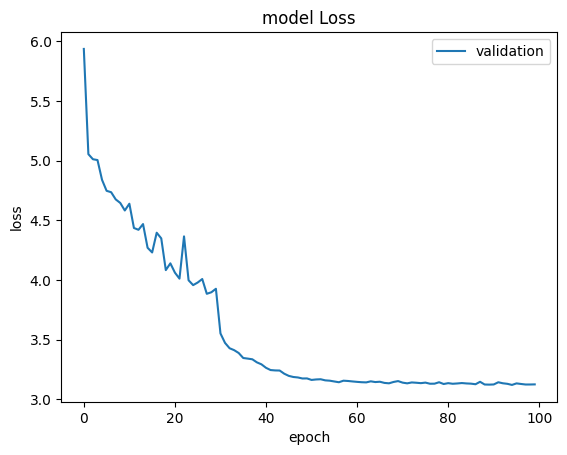

In [ ]:
# valid loss
plt.plot(valid_loss)
plt.title('model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['validation'], loc='best')
plt.show()

## Testing

In [ ]:
# Predict function (output bounding box, not 7*7*30 target)

import torch
from torch.autograd import Variable
import torch.nn as nn
import torchvision.transforms as transforms
import cv2
import numpy as np

VOC_CLASSES = ('aeroplane', 'bicycle', 'bird', 'boat',
        'bottle', 'bus', 'car', 'cat', 'chair',
        'cow', 'diningtable', 'dog', 'horse',
        'motorbike', 'person', 'pottedplant',
        'sheep', 'sofa', 'train', 'tvmonitor')

def decoder(pred, nms_thr=0.5, prob_thr=0.1):
    # turn 1*7*7*30 output into final prediced boxes (decode + nms)
    '''
    pred (tensor) 1x7x7x30, where 30 = 5*2(xywh+confidence for 2 boxes) + 20(classes)
    return (tensor) box[[x1,y1,x2,y2]] label[...]
    '''
    grid_num = GRID_NUM
    boxes=[]
    cls_indexs=[]
    probs = []
    cell_size = 1./grid_num
    pred = pred.data
    pred = pred.squeeze(0) # 7x7x30

    contain1 = pred[:,:,4].unsqueeze(2) # 4, 9: confidence for 2 boxes
    contain2 = pred[:,:,9].unsqueeze(2) # unsqueeze: Size = [7,7,1]
    contain = torch.cat((contain1,contain2),2) # shape: torch.Size([7, 7, 2])

    # mask for confidence (not class probability!)
    mask1 = contain > prob_thr # if confidence < thr, then confidence*max_prob must < thr. So we can discard it now.

    for i in range(grid_num):
        for j in range(grid_num):
          if mask1[i][j][0] and mask1[i][j][1]:
            if contain[i][j][0] >= contain[i][j][1]: 
              mask1[i][j][1] = False
            else:
              mask1[i][j][0] = False

    mask2 = (contain==contain.max())

    mask = (mask1+mask2).gt(0) # .gt(0): whether it is greater than zero 
                   # shape: torch.Size([7, 7, 2])
                   # keep a confidence if it > 0.1 or it is max among all confidence values

    for i in range(grid_num):
        for j in range(grid_num):
            for b in range(2):
                if mask[i,j,b] == 1:
                    box = pred[i,j,b*5:b*5+4] # get delta_x, delat_y, w, h
                    contain_prob = torch.FloatTensor([pred[i,j,b*5+4]])
                    xy = torch.FloatTensor([j,i])*cell_size # up left of cell
                    box[:2] = box[:2]*cell_size + xy # return cxcy relative to image
                    box_xy = torch.FloatTensor(box.size()) # convert[cx,cy,w,h] to [x1,xy1,x2,y2]
                    box_xy[:2] = box[:2] - 0.5*box[2:]
                    box_xy[2:] = box[:2] + 0.5*box[2:]
                    max_prob,cls_index = torch.max(pred[i,j,10:],0) # get the class with max prob

                    if float((contain_prob*max_prob)[0]) > prob_thr: # confidence * prob > 0.1
                        boxes.append(box_xy.view(1,4))
                        cls_indexs.append(cls_index.view(1))
                        probs.append(contain_prob*max_prob)
    # type of boxes, probs, cls_indexs: list of tensors

    if len(boxes) ==0: # ensure output shape, and set probs as 0 so it won't lead to further error.
        boxes = torch.zeros((1,4))
        probs = torch.zeros(1)
        cls_indexs = torch.zeros(1)
    else:
        boxes = torch.cat(boxes,0) #turn list of tensors into [N,4]
        # Debug: RuntimeError: zero-dimensional tensor (at position 0) cannot be concatenated
        # -> add .view(1) to cls_indexs before appending

        probs = torch.cat(probs,0) # [N,]
        cls_indexs = torch.cat(cls_indexs,0) # [N,]

    keep = nms(boxes,probs,nms_thr)
    return boxes[keep],cls_indexs[keep],probs[keep]

def nms(bboxes,scores,threshold=0.5):
    '''
    bboxes(tensor) [N,4]
    scores(tensor) [N,]
    return (tensor) [N,] indexs of the kept boxes
    '''
    x1 = bboxes[:,0]
    y1 = bboxes[:,1]
    x2 = bboxes[:,2]
    y2 = bboxes[:,3]
    areas = (x2-x1) * (y2-y1)

    _,order = scores.sort(0,descending=True) # return sorted values and their original index

    keep = []

    # use order to store the index of remaining boxes.
    # remove selected, discarded indexs for each round, the selected indexs will be stored in keep
    # run until there's no remaaining boxes.

    while order.numel() > 0: # return number of elements
                   # while there're items remain

        # take the first item
        if order.dim() == 0: # when dim()==0, can't use order[0].
            i = order.item() # item(): 
        else: 
            i = order[0]
        keep.append(i)

        if order.numel() == 1: # only 1 item remain: select it and stop.
            break
        
        # calculating the IoU between first item and others

        xx1 = x1[order[1:]].clamp(min=x1[i]) # clamp(min): turn values that < min into min. 
        xx2 = x2[order[1:]].clamp(max=x2[i])
        yy1 = y1[order[1:]].clamp(min=y1[i])
        yy2 = y2[order[1:]].clamp(max=y2[i])

        # weight and height of intersection areas
        w = (xx2-xx1).clamp(min=0)
        h = (yy2-yy1).clamp(min=0)
        inter = w*h
        # iou value of fist item vs other
        ovr = inter / (areas[i] + areas[order[1:]] - inter) 

        # discard those IoU with first item > threshold
        ids = (ovr<=threshold).nonzero().squeeze()
        
        if ids.numel() == 0: # if there's no item remain
            break
        order = order[ids+1]
        # ids+1 = indexs of items to keep for this round
        # ids is calculated for item[1:] 
        # -> before use it as the index of 'order', we have to +1.
        # example:  
        #   original order: tensor([ 6,  0,  4, 18,  7, 17, 14,  9,  1,  3, 13,  5, 11, 10])
        #   ids+1: tensor([ 1,  2,  3,  5,  7,  8,  9, 10, 11, 12, 13])
        #   new order:  tensor([ 0,  4, 18, 17,  9,  1,  3, 13,  5, 11, 10])
        # since the ids has +1, the first item(item with biggest prob) must be eliminated for each round

    return torch.LongTensor(keep)

# predict one image
def predict_gpu(model,image_name,root_path=''):

    result = []
    image = cv2.imread(root_path+image_name)

    h,w,_ = image.shape
    img = cv2.resize(image,(448,448))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    mean = (123,117,104) # RGB
    img = img - np.array(mean,dtype=np.float32)
    transform = transforms.Compose([transforms.ToTensor(),])
    img = transform(img)
    
    with torch.no_grad():
        img = Variable(img[None,:,:,:])
    img = img.cuda()

    pred = model(img) #1x7x7x30
    pred = pred.cpu()
    boxes,cls_indexs,probs = decoder(pred)

    for i,box in enumerate(boxes):
        x1 = int(box[0]*w)
        x2 = int(box[2]*w)
        y1 = int(box[1]*h)
        y2 = int(box[3]*h)
        cls_index = cls_indexs[i]
        cls_index = int(cls_index) # convert LongTensor to int
        prob = probs[i]
        prob = float(prob)
        result.append([(x1,y1),(x2,y2),VOC_CLASSES[cls_index],image_name,prob])
    return result

In [ ]:
# Evaluate function

import numpy as np
def voc_ap(rec,prec):
    mrec = np.concatenate(([0.],rec,[1.]))
    mpre = np.concatenate(([0.],prec,[0.]))

    # smoothen the precision/recall curve (compute the envelope)
    for i in range(mpre.size -1, 0, -1):
        mpre[i-1] = np.maximum(mpre[i-1],mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum the change of recall * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])

    return ap

def voc_eval(preds,target,VOC_CLASSES=VOC_CLASSES,threshold=0.5):
    '''
    preds {'cat':[[image_id,confidence,x1,y1,x2,y2],...],'dog':[[],...]}
    target {(image_id,class):[[],]}
    '''
    aps = []
    for i,class_ in enumerate(VOC_CLASSES):
        pred = preds[class_] # [[image_id,confidence,x1,y1,x2,y2],...]
        if len(pred) == 0: # abnormal case: none of object is detected as this class
            ap = -1
            print('---class {} ap {}---'.format(class_,ap))
            aps += [ap]
            break

        image_ids = [x[0] for x in pred]
        confidence = np.array([float(x[1]) for x in pred])
        BB = np.array([x[2:] for x in pred])
        # sort by confidence
        sorted_ind = np.argsort(-confidence)
        sorted_scores = np.sort(-confidence)
        BB = BB[sorted_ind, :]
        image_ids = [image_ids[x] for x in sorted_ind]

        # go down dets and mark TPs and FPs
        npos = 0.
        for (key1,key2) in target:
            if key2 == class_: # count the positive sameple for this class
                npos += len(target[(key1,key2)]) 
        nd = len(image_ids)
        tp = np.zeros(nd)
        fp = np.zeros(nd)
        for d,image_id in enumerate(image_ids):
            bb = BB[d] # bounding box
            if (image_id,class_) in target:
                BBGT = target[(image_id,class_)] #[[],]
                for bbgt in BBGT:
                    # compute overlaps
                    # intersection
                    ixmin = np.maximum(bbgt[0], bb[0])
                    iymin = np.maximum(bbgt[1], bb[1])
                    ixmax = np.minimum(bbgt[2], bb[2])
                    iymax = np.minimum(bbgt[3], bb[3])
                    iw = np.maximum(ixmax - ixmin + 1., 0.)
                    ih = np.maximum(iymax - iymin + 1., 0.)
                    inters = iw * ih

                    union = (bb[2]-bb[0]+1.)*(bb[3]-bb[1]+1.) + (bbgt[2]-bbgt[0]+1.)*(bbgt[3]-bbgt[1]+1.) - inters
                    if union == 0:
                        print(bb,bbgt)
                    
                    overlaps = inters/union
                    if overlaps > threshold:
                        tp[d] = 1
                        BBGT.remove(bbgt) # the box is already paired
                        if len(BBGT) == 0:
                            del target[(image_id,class_)] # delete the one without box
                        break
                fp[d] = 1-tp[d]
            else:
                fp[d] = 1
        fp = np.cumsum(fp)
        tp = np.cumsum(tp)
        rec = tp/float(npos)
        prec = tp/np.maximum(tp + fp, np.finfo(np.float64).eps)

        ap = voc_ap(rec, prec)
        print('---class {} ap {}---'.format(class_,ap))
        aps += [ap]
    print('---map {}---'.format(np.mean(aps)))

In [ ]:
# Debugging: Evaluating the simulated value

preds = {'cat':[['image01',0.9,20,20,40,40],['image01',0.8,20,20,50,50],['image02',0.8,30,30,50,50]],'dog':[['image01',0.78,60,60,90,90]]}
target = {('image01','cat'):[[20,20,41,41]],('image01','dog'):[[60,60,91,91]],('image02','cat'):[[30,30,51,51]]}
voc_eval(preds,target,VOC_CLASSES=['cat','dog'])

---class cat ap 0.8333333333333333---
---class dog ap 1.0---
---map 0.9166666666666666---


In [ ]:
import cv2

Color = [[0, 0, 0],[128, 0, 0],[0, 128, 0],[128, 128, 0],
      [0, 0, 128],[128, 0, 128],[0, 128, 128],[128, 128, 128],
      [64, 0, 0],[192, 0, 0],[64, 128, 0],[192, 128, 0],
      [64, 0, 128],[192, 0, 128],[64, 128, 128],[192, 128, 128],
      [0, 64, 0],[128, 64, 0],[0, 192, 0],[128, 192, 0],[0, 64, 128]]

def visualize_image(image_name):
    model = ResNetYoloV1(50)
    model.load_state_dict(torch.load(root+'model_best.pth'))
    model.eval()
    model.cuda()

    image = cv2.imread(root+'voc2007test_images/'+image_name)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)


    result = predict_gpu(model,root+'voc2007test_images/'+image_name)
    for left_up,right_bottom,class_name,_,prob in result:
        color = Color[VOC_CLASSES.index(class_name)]
        cv2.rectangle(image,left_up,right_bottom,color,2)
        label = class_name+str(round(prob,2))
        text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
        p1 = (left_up[0], left_up[1]- text_size[1])
        cv2.rectangle(image, (p1[0] - 2//2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]), color, -1)
        cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, 8)

    plt.figure(figsize=(10,10))
    plt.imshow(image)

In [ ]:
## original one, grid_num = 7, epoch = 50, batch_size = 8, decay = 0.0005
# Testing & evaluating model
from collections import defaultdict # don't need to check if the key exists or not
from tqdm import tqdm # visualize progress

target =  defaultdict(list) 
preds = defaultdict(list)
image_list = [] #image path list

# prepare target
f = open(root+'voc2007test.txt')
lines = f.readlines()
file_list = []
for line in lines:
    splited = line.strip().split()
    file_list.append(splited)
f.close()

for index,image_file in enumerate(file_list):
    image_id = image_file[0]

    image_list.append(image_id)
    num_obj = (len(image_file) - 1) // 5
    for i in range(num_obj):
        x1 = int(image_file[1+5*i])
        y1 = int(image_file[2+5*i])
        x2 = int(image_file[3+5*i])
        y2 = int(image_file[4+5*i])
        c = int(image_file[5+5*i])
        class_name = VOC_CLASSES[c]
        target[(image_id,class_name)].append([x1,y1,x2,y2])

# start test
print('---start test---')
model = ResNetYoloV1(50)
model.load_state_dict(torch.load(root+'model_best.pth'))
model.eval()
model.cuda()

# predict
for image_path in tqdm(image_list):
    result = predict_gpu(model,image_path,root_path=root+'voc2007test_images/') 
    # result[[left_up,right_bottom,class_name,image_path],]

    for (x1,y1),(x2,y2),class_name,image_id,prob in result: #image_id is actually image_path
        preds[class_name].append([image_id,prob,x1,y1,x2,y2])
    
# evaluate
print('---start evaluate---')
voc_eval(preds,target,VOC_CLASSES=VOC_CLASSES)

---start test---


100%|██████████| 4951/4951 [02:23<00:00, 34.41it/s]


---start evaluate---
---class aeroplane ap 0.289358374342391---
---class bicycle ap 0.1089469207847369---
---class bird ap 0.0677450696854027---
---class boat ap 0.041205657886835646---
---class bottle ap 0.0006396588486140725---
---class bus ap 0.37586585483765916---
---class car ap 0.4342507963439659---
---class cat ap 0.1332149149226804---
---class chair ap 0.07051238181588494---
---class cow ap 0.04755279595289732---
---class diningtable ap 0.1848576367739937---
---class dog ap 0.12200484989314679---
---class horse ap 0.391090913872239---
---class motorbike ap 0.29868508150357764---
---class person ap 0.36176481052031323---
---class pottedplant ap 0.0003472222222222222---
---class sheep ap 0.010956946458968615---
---class sofa ap 0.14761835654364958---
---class train ap 0.3881953103047714---
---class tvmonitor ap 0.14534717774890582---
---map 0.18100803656314282---


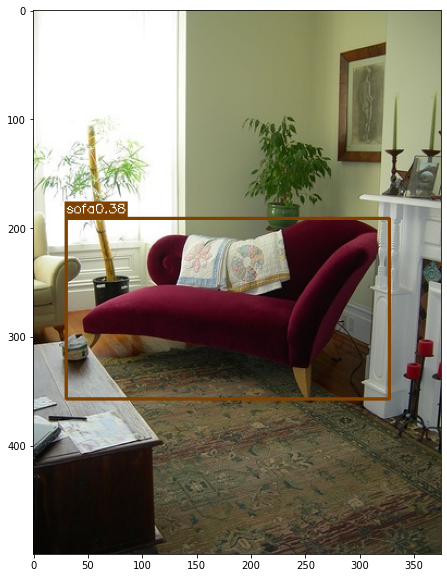

In [ ]:
# Visualizing
visualize_image('000116.jpg')

In [ ]:
## try grid_num =7, epoch = 100, batch_size = 8, decay = 0.0005
## Testing & evaluating model
from collections import defaultdict # don't need to check if the key exists or not
from tqdm import tqdm # visualize progress

target =  defaultdict(list) 
preds = defaultdict(list)
image_list = [] #image path list

# prepare target
f = open(root+'voc2007test.txt')
lines = f.readlines()
file_list = []
for line in lines:
    splited = line.strip().split()
    file_list.append(splited)
f.close()

for index,image_file in enumerate(file_list):
    image_id = image_file[0]

    image_list.append(image_id)
    num_obj = (len(image_file) - 1) // 5
    for i in range(num_obj):
        x1 = int(image_file[1+5*i])
        y1 = int(image_file[2+5*i])
        x2 = int(image_file[3+5*i])
        y2 = int(image_file[4+5*i])
        c = int(image_file[5+5*i])
        class_name = VOC_CLASSES[c]
        target[(image_id,class_name)].append([x1,y1,x2,y2])

# start test
print('---start test---')
model = ResNetYoloV1(50)
model.load_state_dict(torch.load('model_best.pth'))
model.eval()
model.cuda()

# predict
for image_path in tqdm(image_list):
    result = predict_gpu(model,image_path,root_path=root+'voc2007test_images/') 
    # result[[left_up,right_bottom,class_name,image_path],]

    for (x1,y1),(x2,y2),class_name,image_id,prob in result: #image_id is actually image_path
        preds[class_name].append([image_id,prob,x1,y1,x2,y2])
    
# evaluate
print('---start evaluate---')
voc_eval(preds,target,VOC_CLASSES=VOC_CLASSES)

---start test---


100%|████████████████████████████████████████████| 4951/4951 [01:14<00:00, 66.48it/s]


---start evaluate---
---class aeroplane ap 0.28986697659411725---
---class bicycle ap 0.038753297107150496---
---class bird ap 0.0538095651583888---
---class boat ap 0.026367010682600035---
---class bottle ap 0.0---
---class bus ap 0.31693985635527083---
---class car ap 0.3927004024243311---
---class cat ap 0.15472334430573953---
---class chair ap 0.04186323554303213---
---class cow ap 0.05806561247748283---
---class diningtable ap 0.16894426264268186---
---class dog ap 0.08301487464699767---
---class horse ap 0.31024054026476455---
---class motorbike ap 0.24129865350532248---
---class person ap 0.31863082054435177---
---class pottedplant ap 0.0---
---class sheep ap 0.008789419946444738---
---class sofa ap 0.1248335819563808---
---class train ap 0.3044085307188303---
---class tvmonitor ap 0.09724057237173861---
---map 0.15152452786228127---


In [ ]:
## try grid_num =7, epoch = 100, batch_size = 8, decay = 0.001
# Testing & evaluating model
from collections import defaultdict # don't need to check if the key exists or not
from tqdm import tqdm # visualize progress

target =  defaultdict(list) 
preds = defaultdict(list)
image_list = [] #image path list

# prepare target
f = open(root+'voc2007test.txt')
lines = f.readlines()
file_list = []
for line in lines:
    splited = line.strip().split()
    file_list.append(splited)
f.close()

for index,image_file in enumerate(file_list):
    image_id = image_file[0]

    image_list.append(image_id)
    num_obj = (len(image_file) - 1) // 5
    for i in range(num_obj):
        x1 = int(image_file[1+5*i])
        y1 = int(image_file[2+5*i])
        x2 = int(image_file[3+5*i])
        y2 = int(image_file[4+5*i])
        c = int(image_file[5+5*i])
        class_name = VOC_CLASSES[c]
        target[(image_id,class_name)].append([x1,y1,x2,y2])

# start test
print('---start test---')
model = ResNetYoloV1(50)
model.load_state_dict(torch.load('model_best.pth'))
model.eval()
model.cuda()

# predict
for image_path in tqdm(image_list):
    result = predict_gpu(model,image_path,root_path=root+'voc2007test_images/') 
    # result[[left_up,right_bottom,class_name,image_path],]

    for (x1,y1),(x2,y2),class_name,image_id,prob in result: #image_id is actually image_path
        preds[class_name].append([image_id,prob,x1,y1,x2,y2])
    
# evaluate
print('---start evaluate---')
voc_eval(preds,target,VOC_CLASSES=VOC_CLASSES)

---start test---


100%|████████████████████████████████████████████| 4951/4951 [01:18<00:00, 63.16it/s]


---start evaluate---
---class aeroplane ap 0.3539920470594211---
---class bicycle ap 0.1832291665007207---
---class bird ap 0.08248933054773176---
---class boat ap 0.0481636213729146---
---class bottle ap 0.0005330490405117271---
---class bus ap 0.3468303624402004---
---class car ap 0.44716500082503763---
---class cat ap 0.14028170456196767---
---class chair ap 0.07245550026408905---
---class cow ap 0.05244221915003487---
---class diningtable ap 0.2325276256014084---
---class dog ap 0.11493747611393411---
---class horse ap 0.3526185410770243---
---class motorbike ap 0.2932530157283699---
---class person ap 0.37250217465249497---
---class pottedplant ap 0.0014423076923076924---
---class sheep ap 0.021571952814441762---
---class sofa ap 0.1757637323703877---
---class train ap 0.3782604639518275---
---class tvmonitor ap 0.19124805393282748---
---map 0.19308536728488268---


In [ ]:
# try grid_num =7, epoch = 100, batch_size = 12, decay = 0.001
# Testing & evaluating model
from collections import defaultdict # don't need to check if the key exists or not
from tqdm import tqdm # visualize progress

target =  defaultdict(list) 
preds = defaultdict(list)
image_list = [] #image path list

# prepare target
f = open(root+'voc2007test.txt')
lines = f.readlines()
file_list = []
for line in lines:
    splited = line.strip().split()
    file_list.append(splited)
f.close()

for index,image_file in enumerate(file_list):
    image_id = image_file[0]

    image_list.append(image_id)
    num_obj = (len(image_file) - 1) // 5
    for i in range(num_obj):
        x1 = int(image_file[1+5*i])
        y1 = int(image_file[2+5*i])
        x2 = int(image_file[3+5*i])
        y2 = int(image_file[4+5*i])
        c = int(image_file[5+5*i])
        class_name = VOC_CLASSES[c]
        target[(image_id,class_name)].append([x1,y1,x2,y2])

# start test
print('---start test---')
model = ResNetYoloV1(50)
model.load_state_dict(torch.load('model_best.pth'))
model.eval()
model.cuda()

# predict
for image_path in tqdm(image_list):
    result = predict_gpu(model,image_path,root_path=root+'voc2007test_images/') 
    # result[[left_up,right_bottom,class_name,image_path],]

    for (x1,y1),(x2,y2),class_name,image_id,prob in result: #image_id is actually image_path
        preds[class_name].append([image_id,prob,x1,y1,x2,y2])
    
# evaluate
print('---start evaluate---')
voc_eval(preds,target,VOC_CLASSES=VOC_CLASSES)

---start test---


100%|████████████████████████████████████████████| 4951/4951 [01:15<00:00, 65.63it/s]


---start evaluate---
---class aeroplane ap 0.3768468918536645---
---class bicycle ap 0.37113757752005505---
---class bird ap 0.14552860742367274---
---class boat ap 0.08310484752565325---
---class bottle ap 0.0036024971217429977---
---class bus ap 0.4518063530472319---
---class car ap 0.5191973028131418---
---class cat ap 0.26002666065684676---
---class chair ap 0.1042273200485257---
---class cow ap 0.13179971070152816---
---class diningtable ap 0.3128595934708827---
---class dog ap 0.174843074563939---
---class horse ap 0.47215631212613135---
---class motorbike ap 0.3736130456530561---
---class person ap 0.4309281963242669---
---class pottedplant ap 0.021721451351932854---
---class sheep ap 0.04830080362708923---
---class sofa ap 0.28107710621487686---
---class train ap 0.4712672376686412---
---class tvmonitor ap 0.25585183469992534---
---map 0.2644948212206402---


In [ ]:
# try grid_num =14, epoch = 100, batch_size = 12, decay = 0.001
# Testing & evaluating model
from collections import defaultdict # don't need to check if the key exists or not
from tqdm import tqdm # visualize progress

target =  defaultdict(list) 
preds = defaultdict(list)
image_list = [] #image path list

# prepare target
f = open(root+'voc2007test.txt')
lines = f.readlines()
file_list = []
for line in lines:
    splited = line.strip().split()
    file_list.append(splited)
f.close()

for index,image_file in enumerate(file_list):
    image_id = image_file[0]

    image_list.append(image_id)
    num_obj = (len(image_file) - 1) // 5
    for i in range(num_obj):
        x1 = int(image_file[1+5*i])
        y1 = int(image_file[2+5*i])
        x2 = int(image_file[3+5*i])
        y2 = int(image_file[4+5*i])
        c = int(image_file[5+5*i])
        class_name = VOC_CLASSES[c]
        target[(image_id,class_name)].append([x1,y1,x2,y2])

# start test
print('---start test---')
model = ResNetYoloV1(50)
model.load_state_dict(torch.load('model_best.pth'))
model.eval()
model.cuda()

# predict
for image_path in tqdm(image_list):
    result = predict_gpu(model,image_path,root_path=root+'voc2007test_images/') 
    # result[[left_up,right_bottom,class_name,image_path],]

    for (x1,y1),(x2,y2),class_name,image_id,prob in result: #image_id is actually image_path
        preds[class_name].append([image_id,prob,x1,y1,x2,y2])
    
# evaluate
print('---start evaluate---')
voc_eval(preds,target,VOC_CLASSES=VOC_CLASSES)

---start test---


100%|████████████████████████████████████████████| 4951/4951 [01:33<00:00, 52.85it/s]


---start evaluate---
---class aeroplane ap 0.3947636756076015---
---class bicycle ap 0.44418736655411184---
---class bird ap 0.14967742404575274---
---class boat ap 0.13882575810488237---
---class bottle ap 0.01179359124925411---
---class bus ap 0.4530109260092974---
---class car ap 0.5780595300935883---
---class cat ap 0.292884690096315---
---class chair ap 0.14913688831221464---
---class cow ap 0.1688108353239917---
---class diningtable ap 0.3053421887641712---
---class dog ap 0.2079867521177967---
---class horse ap 0.49499007918448834---
---class motorbike ap 0.4249866414874228---
---class person ap 0.4882421455444227---
---class pottedplant ap 0.022999214852136535---
---class sheep ap 0.12592760387956184---
---class sofa ap 0.28869586124324564---
---class train ap 0.4811810327400709---
---class tvmonitor ap 0.2943040396172399---
---map 0.2957903122413783---


## Report
### Implement
Data Augmentation: We've tried below random transformation.
* random brightness, saturation, hue, blur
* random shift, scale, crop, flip

Other Preprocessing:

* Subtract mean, resize, normalize h,w features into [0,1], and turn into bgr value(used by pytorch pretrained model),
* Encoding the boxes into grid_num * grid_num * 30 target: use w, h, offset of x,y, w, h (all fall into [0,1]), and corresponding box index to represent a box.
- Before doing evaluation, we’ll decode the outputs into real boxes as the original input format. The decoding process is just the inverse of our preprocessing/encoding process.

Loss: 
1. `YoloLoss` : As same as Yolov1 paper

Model Construction:
1. Use `Resnet50` as backbone
2. Use another FCN to after the Resnet50 and output the feature map (i.e. 30*7*7) without implmenting a fully connected layer.

    -> We think a fully connected layer might lose the saptial information.
    The structure of this FCN is similar to the residual block. We set the expansion of channel to 1 since we want to shrink the channel size to 30. Finally, we output the feature map after a batch-norm.


Training Process: 
1. Tried to use different learning_rate during different number of epochs
    
Prediction and Evaluation: 

As same as the strategy/criterion in Yolov1 paper.

### Final Result
Experients:
1. grid_num = 7, epoch = 50, batch_size = 8, decay = 0.0005: mAP = 0.18
2. grid_num = 7, epoch = 100, batch_size = 8, decay = 0.001: mAP = 0.19
3. grid_num = 14, epoch = 50, batch_size = 8, decay = 0.0005: mAP = 0.22
4. grid_num = 7, epoch = 100, batch_size = 12, decay = 0.001: mAP = 0.26
5. try grid_num =14, epoch = 100, batch_size = 12, decay = 0.001: mAP = 0.2957

Guess the reason about performance:
1. batch_size is too small (Run out of memory QQ)
2. grid_num 
3. number of image isn't enough

### Others
Attemptions:
1. Try to build Yolov2 but the result is lower than Yolov1(We still working on it and could not figure out why QQ) 
2. Try to use Voc2012 (remove the 2007 images in it),  but its training takes too long.
3. Try to use a larger gird_num(i.e. 14) and successfully increased the mAP from 18% to 22%.

Difficulty:
1. Python version and cuda problem
2. Split the whole Yolo to several parts to everyone to build
3. Shape of matrix when doing matrix calculation